## Problme Statement:


Elo is one of the largest payment brands in Brazil majorly working with
Debit and Credit cards payments. Elo has partnerships with different
merchants in order to offer promotions and discounts to cardholders.
Elo has built machine learning models to understand the most
important aspects and preferences in their customers lifecycle,from
food to shopping.However there is limitation with the model they have
developed and so far none of them is specifically tailored for an
individual or profile.That means currently Elo has limitation where Elo
cannot recommend fully personalize brand recommendation to its
customers nor they are able to stop unwanted campaign .Here each
customer or cardholder has given a loyalty score which will tell us
whether recommended promotions or discounts works for cardholder
or not.
This problem is a regression problem where we need to predict the
cardholders loyalty score.In train data we have loyalty score for each
card and for the test data we don’t have a loyalty score which model
needs to predict or calculate.Loyalty score is numerical score which is
calculated two months after historical and evaluation period of many
factors including cards transactions .

###Root mean squared error (RMSE): 

1. RMSE is a quadratic scoring rule that measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.

2. Taking the square root of the average squared errors has some interesting facts for RMSE. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable.

3. RMSE does not necessarily increase with the variance of the errors. RMSE increases with the variance of the frequency distribution of error magnitudes.
RMSE is negativly oriented means lower the RMSE score better it is,also it can range from 0 to infinity.

4. We have used RMSE as evaluation matric for this problem because we have almost 1% of datapoints far away from the all other data points and these points are having loyalty score of -33 and which are not also outliars, it means when we are calculating the difference between the squared of the actual and predicetd loyalty score and if these difference are large erros it should penlize while evaluation.

In [ ]:
pip install optuna

     |████████████████████████████████| 302 kB 4.0 MB/s 
     |████████████████████████████████| 164 kB 33.2 MB/s 
     |████████████████████████████████| 80 kB 8.5 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 111 kB 42.7 MB/s 
     |████████████████████████████████| 141 kB 38.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=78f64525f3ae4c40278cf5e08283e41ef9697a29aaac51534acd2390b036eba4
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


##1. Exploratory Data Analysis:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pylab 
import scipy.stats as stats
import datetime
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import optuna
optuna.logging.set_verbosity(20)
from tqdm import tqdm 
import gc
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import log_loss
import lightgbm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from prettytable import PrettyTable
import prettytable

### 1.1 Data Loading:

In [ ]:
## Reference: https://www.kaggle.com/rinnqd/reduce-memory-usage
def reduce_mem_usage(df, verbose=True):
  '''This function helps reduce memmory occuipied by 
     convertig the value to its rqquired data type'''

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/sample_submission.csv')
sample_submission


,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0
...,...,...
123618,C_ID_7a239d2eda,0
123619,C_ID_75ace375ae,0
123620,C_ID_21d56d950c,0
123621,C_ID_6c46fc5a9d,0


In [ ]:
train_dic = pd.read_excel('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/Data_Dictionary.xlsx', sheet_name='train')
train_dic

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [ ]:
#Loading all data files from goole drive
train = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/train.csv', parse_dates=["first_active_month"]))
test = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/test.csv', parse_dates=["first_active_month"]))
historical_transactions = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/historical_transactions.csv',parse_dates=['purchase_date']))
merchants = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/merchants.csv'))
new_merchant_transctions = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/new_merchant_transactions.csv',parse_dates=["purchase_date"]))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 30.32 Mb (46.0% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [ ]:
p_train=train[train['card_id']=='C_ID_0ab67a22ab']
p_test=test[test['card_id']=='C_ID_0ab67a22ab']
p_historical_transactions=historical_transactions[historical_transactions['card_id']=='C_ID_0ab67a22ab']
p_new_merchant_transctions=new_merchant_transctions[new_merchant_transctions['card_id']=='C_ID_0ab67a22ab']

In [ ]:
p_train.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/p_train.csv",index=False)
p_test.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/p_test.csv",index=False)
p_historical_transactions.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/p_historical_transactions.csv",index=False)
p_new_merchant_transctions.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/p_new_merchant_transctions.csv",index=False)

In [ ]:
print("Max loyalty score: ",train.target.max())
print("Min loyalty score: ",train.target.min())

Max loyalty score:  17.97
Min loyalty score:  -33.22


In [ ]:
def add_target_class (row):
   if row['target'] >0 and  row['target']<=20:
      return 1
   #if row['target'] >10 and  row['target']<=20:
   #   return 2
   #if row['target'] >20 and  row['target']<=20 :
   #   return 3
   if row['target'] <0 and  row['target']>=-35:
      return 2
   #if row['target'] <-10 and  row['target']>=-35:
   #   return 4
   #if row['target'] <-20 and  row['target']>=-35:
   #   return 5


  #0-1-->1,1-10-->2,10-20-->3,0 to -1-->4,-1 to -10-->5 and -10 to -35-->6

In [ ]:
train["target_class"]=train.apply(lambda row: add_target_class(row), axis=1)

0-1-->1,1-10-->2,10-20-->3,0 to -1-->4,-1 to -10-->5 and -10 to -35-->6

###1.2 Train and Test dataset Overview:

In [ ]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [ ]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


Observations:

We can see that target column is missing in test data which model has to predict afterwards.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  201917 non-null  datetime64[ns]
 1   card_id             201917 non-null  object        
 2   feature_1           201917 non-null  int64         
 3   feature_2           201917 non-null  int64         
 4   feature_3           201917 non-null  int64         
 5   target              201917 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  123622 non-null  datetime64[ns]
 1   card_id             123623 non-null  object        
 2   feature_1           123623 non-null  int64         
 3   feature_2           123623 non-null  int64         
 4   feature_3           123623 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 4.7+ MB


In [ ]:
train.describe()

,feature_1,feature_2,feature_3,target
count,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636
std,1.186160,0.751362,0.495683,3.850500
min,1.000000,1.000000,0.000000,-33.219281
25%,2.000000,1.000000,0.000000,-0.883110
50%,3.000000,2.000000,1.000000,-0.023437
75%,4.000000,2.000000,1.000000,0.765453
max,5.000000,3.000000,1.000000,17.965068


In [ ]:
test.describe()

,feature_1,feature_2,feature_3
count,123623.00000,123623.000000,123623.000000
mean,3.10926,1.741796,0.564377
std,1.18911,0.749195,0.495840
min,1.00000,1.000000,0.000000
25%,2.00000,1.000000,0.000000
50%,3.00000,2.000000,1.000000
75%,4.00000,2.000000,1.000000
max,5.00000,3.000000,1.000000


Observations:

Here the train and test data looks equally distributed as there are similarity in mean,std,min/max and quntile values.It seems that while spliting data they have used stratified sampling. 

In [ ]:
print("Shape of the train data:",train.shape)
print("Shape of the test data:",test.shape)

Shape of the train data: (201917, 6)
Shape of the test data: (123623, 5)


#### Analyzing Null Values:

In [ ]:
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [ ]:
test.isnull().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

Observations:

One null value present in "first_active_month" column of test data which we can impute with mean or mode.For train we dont find any null values.

####Analyzing Card Duplication and Overlapping:

In [ ]:
print("Duplicate cards in train data:",train.duplicated(subset=["card_id"]).sum())
print("Duplicate cards in test data:",test.duplicated(subset=["card_id"]).sum())

Duplicate cards in train data: 0
Duplicate cards in test data: 0


In [ ]:
print("Checking if card id's of test present in train data:",train.card_id.isin(test.card_id).sum())
print("Checking if card id's of train present in test data:",test.card_id.isin(train.card_id).sum())

Checking if card id's of test present in train data: 0
Checking if card id's of train present in test data: 0


Observations:

No duplicate card details found as well as there is no overlapping of cards data of train over test and vice versa.

In [ ]:
#sns.catplot(x="feature_1", y="target", hue="target_class", kind="bar", data=train)
#sns.boxplot(x="feature_1", y="target_class",data=train, linewidth=2.5)
#sns.stripplot(x="feature_1", y="target", hue="target_class", data=train)

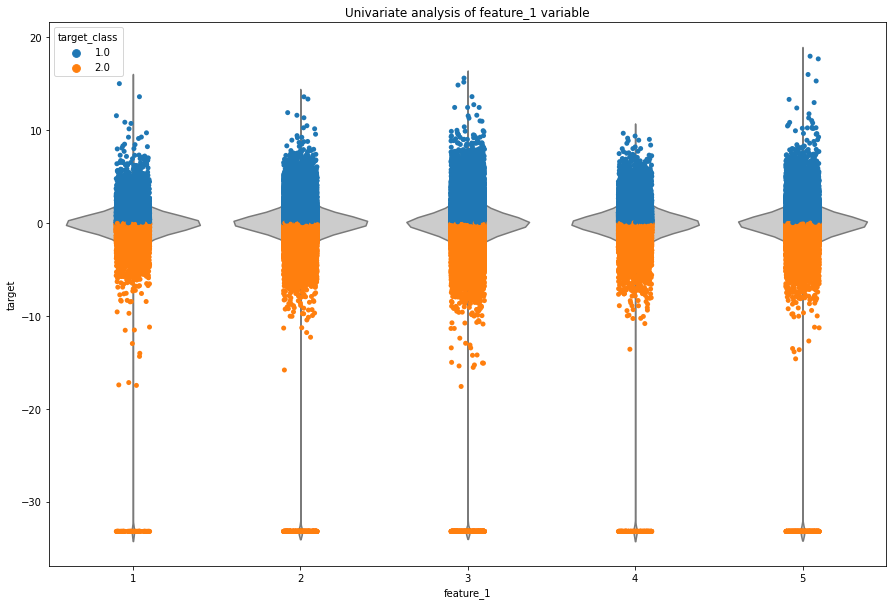

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x="feature_1", y="target",data=train, color=".8")
ax = sns.stripplot(x="feature_1", y="target",hue="target_class", data=train)
plt.title("Univariate analysis of feature_1 variable")
plt.show()

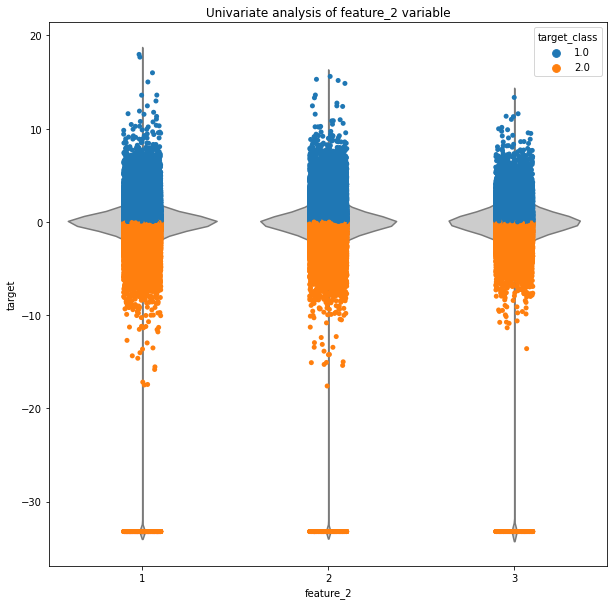

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.violinplot(x="feature_2", y="target",data=train, color=".8")
ax = sns.stripplot(x="feature_2", y="target",hue="target_class", data=train)
plt.title("Univariate analysis of feature_2 variable")
plt.show()

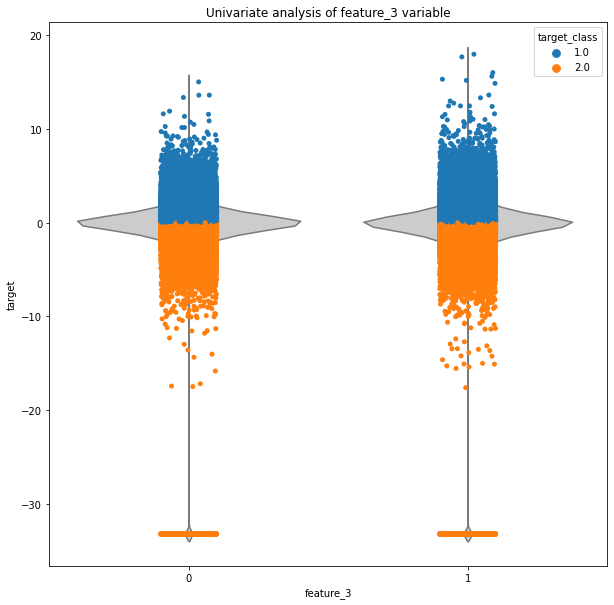

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.violinplot(x="feature_3", y="target",data=train, color=".8")
ax = sns.stripplot(x="feature_3", y="target",hue="target_class", data=train)
plt.title("Univariate analysis of feature_3 variable")
plt.show()

Observations:

Categorical features feature_1,feature_2 and feature_3 are almost equally important for loyalty score prediction as it has spread equally.Also one thing is common in all the features are few points are above -30 which may not be the outliers and having significant impact on evaluation.

In [ ]:
for df in [historical_transactions,new_merchant_transctions]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['day']=df['purchase_date'].dt.day
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0})
    df['category_3'] = df['category_3'].map({'A':1, 'B':2,'C':3,'D':4})
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['installments']=df['installments'].map({-1:14, 0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:9,10:10,11:11,12:12,999:13})
    df['price']=df['purchase_amount']/df['installments']
    df['purchase_amount_quantiles']= pd.qcut(df['purchase_amount'], 5, labels=False)
    df['installments_quantiles']= pd.qcut(df['installments'], 5, labels=False,duplicates='drop')
    df['amount_month_ratio'] = df['purchase_amount'].values / (1.0 + df['month_diff'].values)

gc.collect()

21

In [ ]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [ ]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']
aggs['installments_quantiles']=['var', 'mean', 'skew']
aggs['purchase_amount_quantiles']=['var', 'mean', 'skew']

for col in ['category_2','category_3']:
    historical_transactions[col+'_mean'] = historical_transactions.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    
    
new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = historical_transactions.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
train = train.merge(df_hist_trans_group,on='card_id',how='left')
test = test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group
gc.collect()

Mem. usage decreased to 2415.44 Mb (73.2% reduction)
Mem. usage decreased to 155.38 Mb (62.8% reduction)


0

In [ ]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']
aggs['installments_quantiles']=['var', 'mean', 'skew']
aggs['purchase_amount_quantiles']=['var', 'mean', 'skew']


for col in ['category_2','category_3']:
    new_merchant_transctions[col+'_mean'] = new_merchant_transctions.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']

new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = new_merchant_transctions.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
train = train.merge(df_hist_trans_group,on='card_id',how='left')
test = test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;
gc.collect()

In [ ]:
for df in [train,test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['days_feature1'] = df['elapsed_time'] * df['feature_1']   


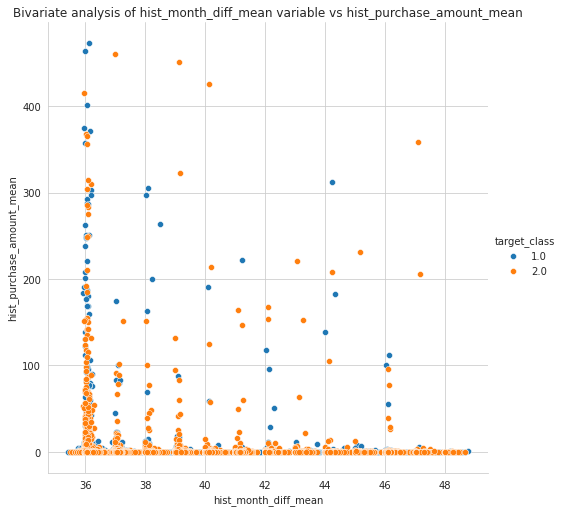

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train[train.hist_purchase_amount_mean<500], hue="target_class",height=7) \
   .map(sns.scatterplot, "hist_month_diff_mean", "hist_purchase_amount_mean") \
   .add_legend();
plt.title("Bivariate analysis of hist_month_diff_mean variable vs hist_purchase_amount_mean")
plt.show();

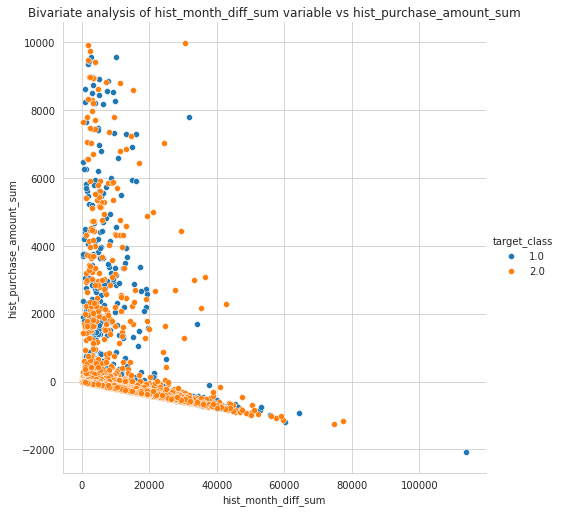

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train[train.hist_purchase_amount_sum<10000], hue="target_class",height=7) \
   .map(sns.scatterplot, "hist_month_diff_sum", "hist_purchase_amount_sum") \
   .add_legend();
plt.title("Bivariate analysis of hist_month_diff_sum variable vs hist_purchase_amount_sum")
plt.show();

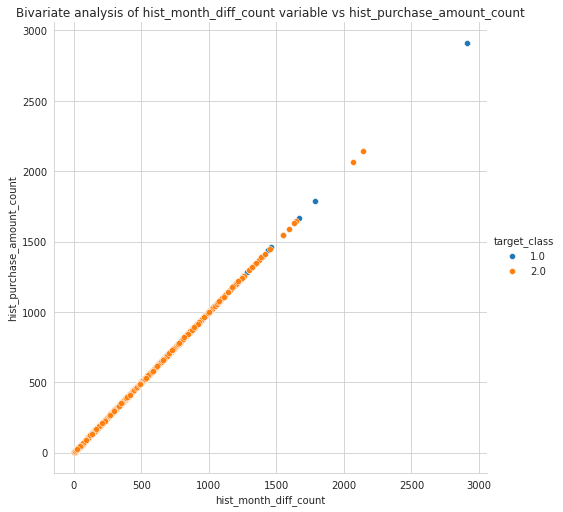

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train, hue="target_class",height=7) \
   .map(sns.scatterplot, "hist_month_diff_count", "hist_purchase_amount_count") \
   .add_legend();
plt.title("Bivariate analysis of hist_month_diff_count variable vs hist_purchase_amount_count")
plt.show();

Observations:

1. In bivariate analysis scatter plot of hist_month_diff_mean variable vs hist_purchase_amount_mean we have found there are more datapoints between hist_month_diff_mean(36) and hist_purchase_amount_mean(100) but these points are all mixed and we are not able to separte positive loyalty score from negative loyalty score as we dont see any relationship between these two feature.

2. In other two plots we have not seen any relationship which can separate loyalty score.

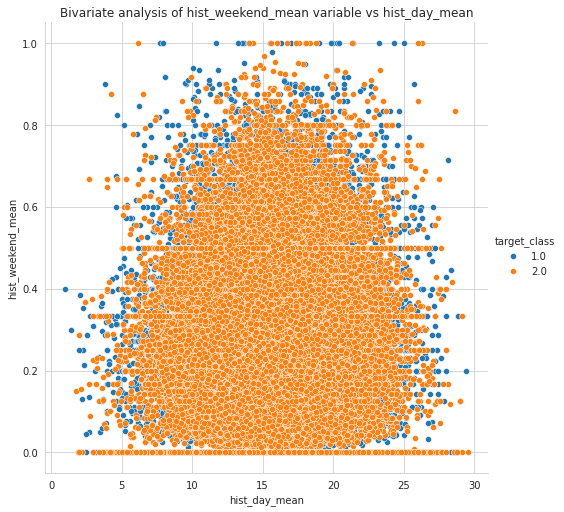

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train, hue="target_class",height=7) \
   .map(sns.scatterplot, "hist_day_mean", "hist_weekend_mean") \
   .add_legend();
plt.title("Bivariate analysis of hist_weekend_mean variable vs hist_day_mean")
plt.show();

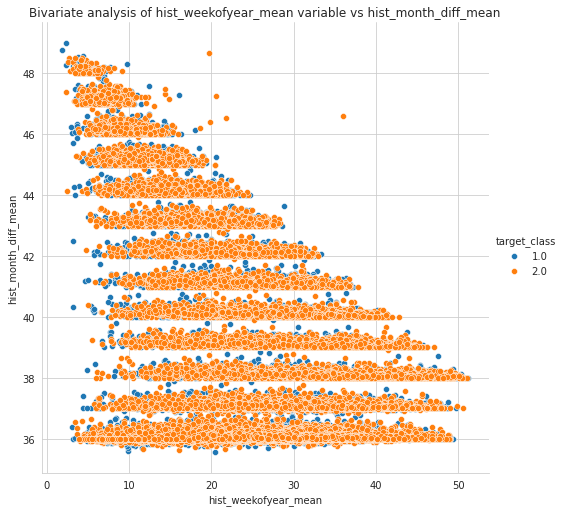

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train[train.hist_purchase_amount_mean<500000], hue="target_class",height=7) \
   .map(sns.scatterplot, "hist_weekofyear_mean", "hist_month_diff_mean") \
   .add_legend();
plt.title("Bivariate analysis of hist_weekofyear_mean variable vs hist_month_diff_mean")
plt.show();

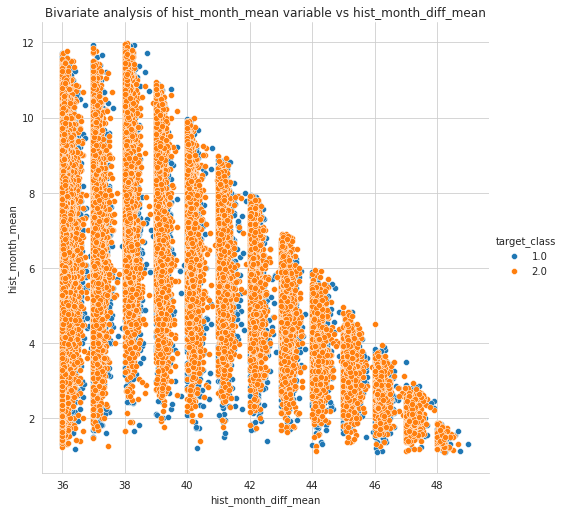

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train, hue="target_class",height=7) \
   .map(sns.scatterplot, "hist_month_diff_mean", "hist_month_mean") \
   .add_legend();
plt.title("Bivariate analysis of hist_month_mean variable vs hist_month_diff_mean")
plt.show();

Observations:

1. Bivariate analysis of hist_weekend_mean variable vs hist_day_mean: Here we dont find any relation between these two variable which will separate positive loyalty score with respect to negative one,however we we can say that users are not purchasing at the begining and end of the month.

2. Bivariate analysis of hist_weekofyear_mean variable vs hist_month_diff_mean: Here also we dont find any linear relationship between the variables,however we found some data pattern whcih indicates purchasing month difference is between 36 to 40 then those user always make shoping in all the week of year and the purchase month diff is more than 40 then they are doing shopping on some festive month here in this case Jan to Apr month.

3. Bivariate analysis of hist_month_mean variable vs hist_month_diff_mean: This is also same as second plot above just diff is here we have consider month instead of week of the year variable.

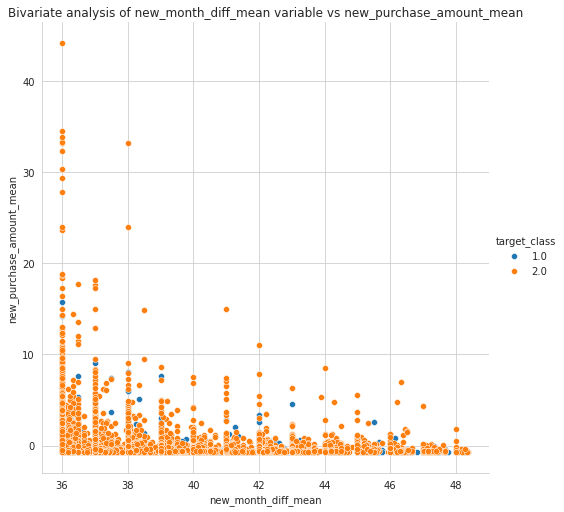

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train, hue="target_class",height=7) \
   .map(sns.scatterplot, "new_month_diff_mean", "new_purchase_amount_mean") \
   .add_legend();
plt.title("Bivariate analysis of new_month_diff_mean variable vs new_purchase_amount_mean")
plt.show();

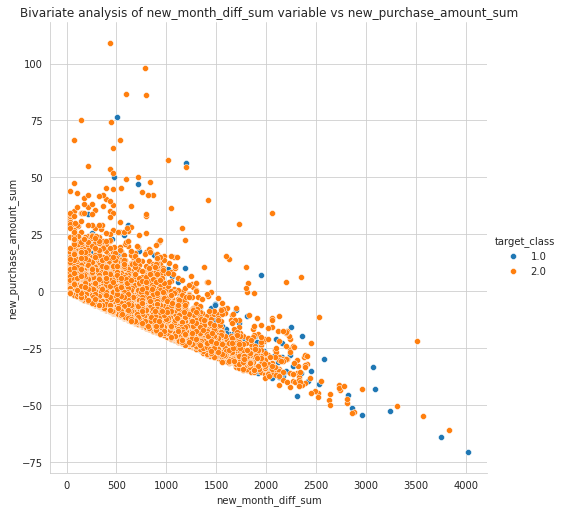

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train[train.hist_purchase_amount_sum<10000], hue="target_class",height=7) \
   .map(sns.scatterplot, "new_month_diff_sum", "new_purchase_amount_sum") \
   .add_legend();
plt.title("Bivariate analysis of new_month_diff_sum variable vs new_purchase_amount_sum")
plt.show();

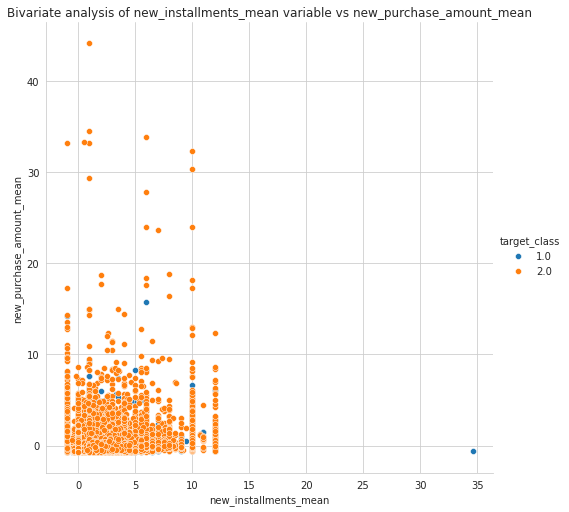

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train, hue="target_class",height=7) \
   .map(sns.scatterplot, "new_installments_mean", "new_purchase_amount_mean") \
   .add_legend();
plt.title("Bivariate analysis of new_installments_mean variable vs new_purchase_amount_mean")
plt.show();

Observations:

In all the above plots we are not able to find any strong relationship between the variables which will help us to identify positve loyalty score,however we found some common pattern.

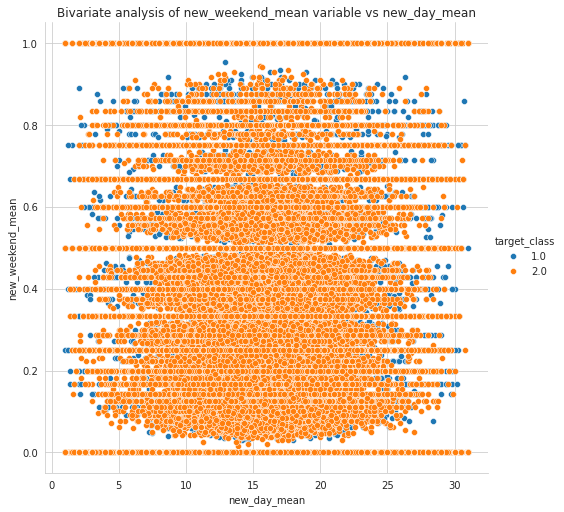

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train, hue="target_class",height=7) \
   .map(sns.scatterplot, "new_day_mean", "new_weekend_mean") \
   .add_legend();
plt.title("Bivariate analysis of new_weekend_mean variable vs new_day_mean")
plt.show();

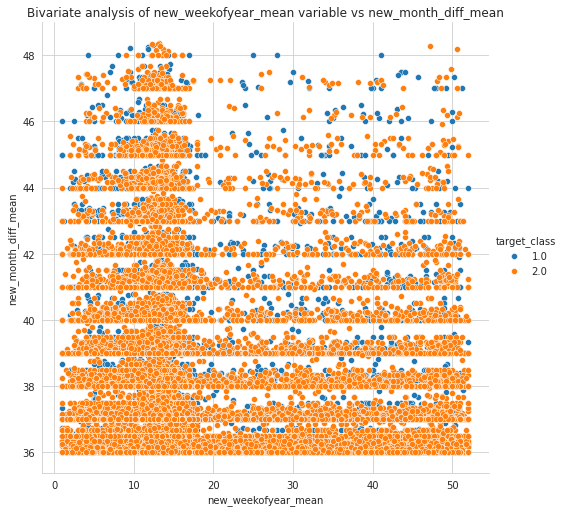

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train[train.hist_purchase_amount_mean<500000], hue="target_class",height=7) \
   .map(sns.scatterplot, "new_weekofyear_mean", "new_month_diff_mean") \
   .add_legend();
plt.title("Bivariate analysis of new_weekofyear_mean variable vs new_month_diff_mean")
plt.show();

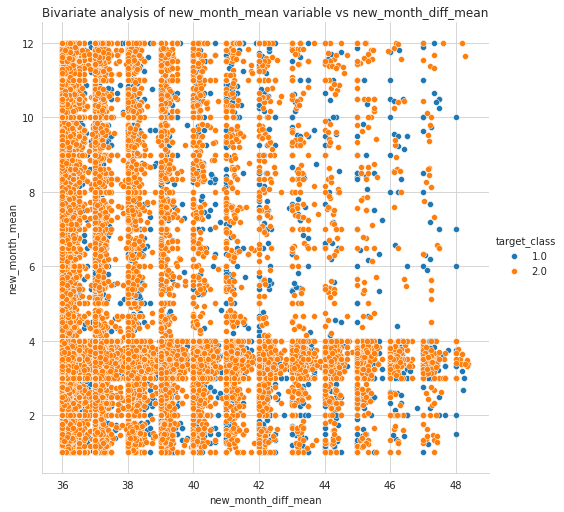

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train, hue="target_class",height=7) \
   .map(sns.scatterplot, "new_month_diff_mean", "new_month_mean") \
   .add_legend();
plt.title("Bivariate analysis of new_month_mean variable vs new_month_diff_mean")
plt.show();

Observations:

1. Bivariate analysis of new_weekend_mean variable vs new_day_mean: Here we can see data points spread all across and jumbled up.

2. Bivariate analysis of new_weekofyear_mean variable vs new_month_diff_mean: Unlike hist transaction data new transactions data spread for whole year irrespective of specifc month.

3. Bivariate analysis of new_month_mean variable vs new_month_diff_mean: Here also we got some data pattern which may be useful for predictions.

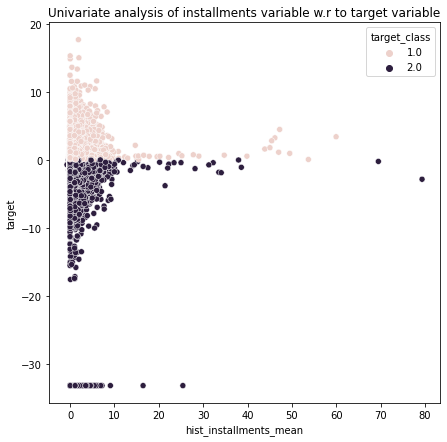

In [ ]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(x="hist_installments_mean",y="target",hue="target_class",data=train)
plt.title("Univariate analysis of installments variable w.r to target variable")
plt.show()

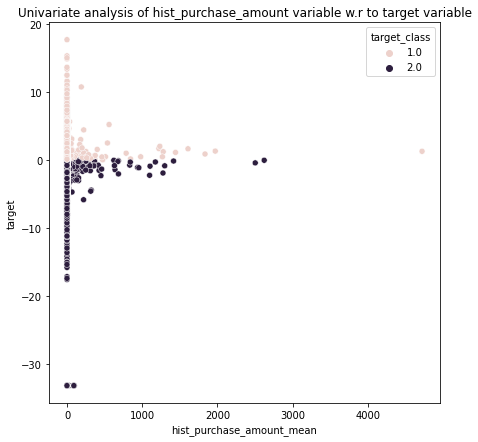

In [ ]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(x="hist_purchase_amount_mean",y="target",hue="target_class",data=train[train.hist_purchase_amount_mean<500000])
plt.title("Univariate analysis of hist_purchase_amount variable w.r to target variable")
plt.show()

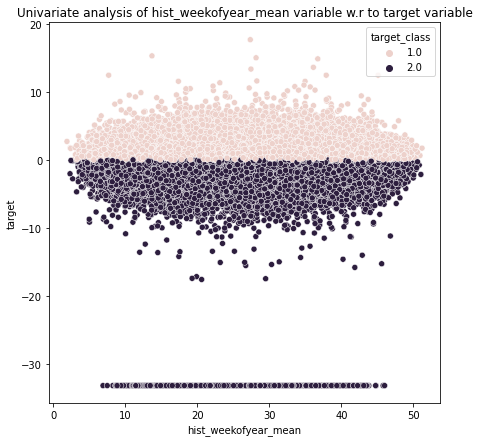

In [ ]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(x="hist_weekofyear_mean",y="target",hue="target_class",data=train)
plt.title("Univariate analysis of hist_weekofyear_mean variable w.r to target variable")
plt.show()

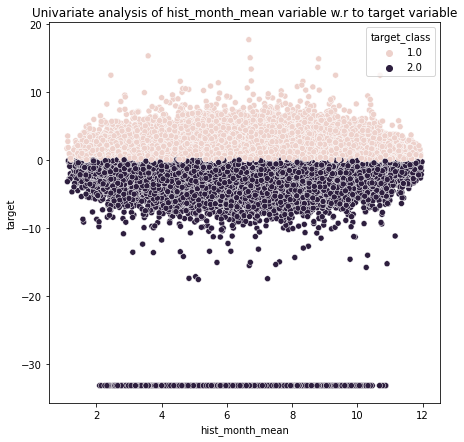

In [ ]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(x="hist_month_mean",y="target",hue="target_class",data=train)
plt.title("Univariate analysis of hist_month_mean variable w.r to target variable")
plt.show()

Observations:
1. Most of the transactions happen with 0-2 installments and plot is also showing more datapoints are present between this range.

2. Most of the Purchase amount is spread between 0-1000 and there are certain amount transactions which are very huge which we can ignore or impute with some mean values.

3. For 3rd and 4th plot above we can see that more transaction happen between week 20 to 40 and month 4-8.

###1.3 Loyalty Score Distribution:

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


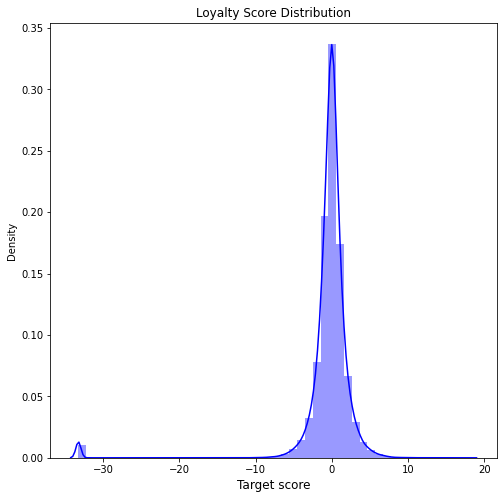

In [ ]:
#Histogram for target variable from train set
plt.figure(figsize=(8,8))
sns.distplot(train['target'].values, color="blue")
plt.title("Loyalty Score Distribution")
plt.xlabel('Target score', fontsize=12)
plt.show()

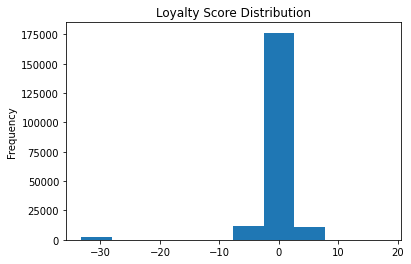

In [ ]:
train.target.plot(kind='hist',title='Loyalty Score Distribution')

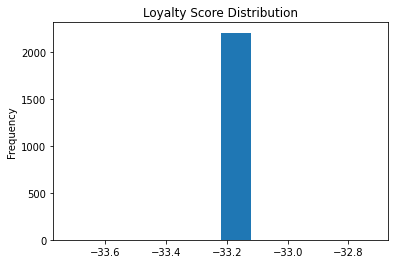

In [ ]:
train.target[train.target<-20].plot(kind='hist',title='Loyalty Score Distribution')

In [ ]:
print("Number of data points with loyalty score below -30: ",train.target[train.target<-30].count())
print("Number of data points with loyalty score not below the -30 : ",train.target[train.target>-30].count())

Number of data points with loyalty score below -30:  2207
Number of data points with loyalty score not below the -30 :  199710


Observations:

Roughly 98% of the data points lies between -1 and +1 and 99%  between -10 and +10.Only 1% of data points are having loyalty score less than -30 whcih are 2207 data points.It seems to be an outliers but we needd to investigate if we can remove these points are not.As we are using RMSE evaluation metrics it may have impacted because of this removal and hence we need to experiment with this before removal of these data points.

In [ ]:
# 0 to 100th percentiles of std-normal
for i in range(0,101,10):
    print(i, np.percentile(train.target,i))

0 -33.21928095
10 -2.04229431
20 -1.146040722
30 -0.6639652260000001
40 -0.31219633399999974
50 -0.02343689
60 0.23619123199999978
70 0.5645080539999998
80 1.014255022
90 1.8302802179999997
100 17.9650684


In [ ]:
# 90 to 100th percentiles of std-normal
for i in range(90,101,1):
    print(i, np.percentile(train.target,i))

90 1.8302802179999997
91 1.9592543887999998
92 2.1068033768000003
93 2.2834347468000007
94 2.4748726335999978
95 2.702680231999998
96 2.9931944891999986
97 3.3676959423999993
98 3.878412985999999
99 4.812662001999994
100 17.9650684


Observations:

It shows most of the values lies between -1 to +1 and also present some extreme value score whcih we need to investigate.

###1.4 Q-Q Plot:

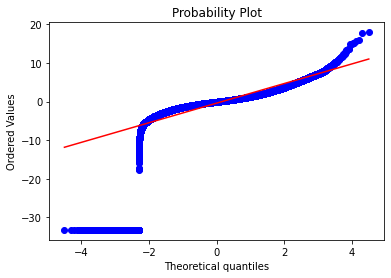

In [ ]:
stats.probplot(train.target, dist="norm", plot=pylab)
pylab.show()

Observations:

Q-Q plots shows us that it is not following Normal/Gaussian distribution for whole data but most of the points lies between -1 to +1.we can also see few points which are far away from majority of the points.

###1.5 Anonymized card categorical feature:

In [ ]:
print("Unique fetaure values for feature_1: ",train.feature_1.unique())
print("Unique fetaure values for feature_2: ",train.feature_2.unique())
print("Unique fetaure values for feature_3: ",train.feature_3.unique())

Unique fetaure values for feature_1:  [5 4 2 1 3]
Unique fetaure values for feature_2:  [2 1 3]
Unique fetaure values for feature_3:  [1 0]


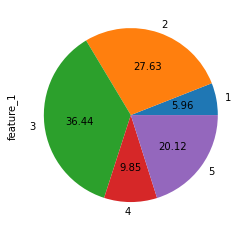

In [ ]:
train['feature_1'].value_counts().sort_index().plot(kind='pie',autopct='%.2f')

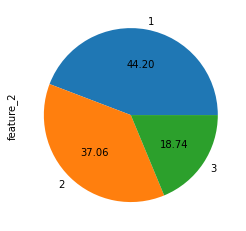

In [ ]:
train['feature_2'].value_counts().sort_index().plot(kind='pie',autopct='%.2f')

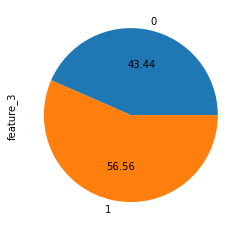

In [ ]:
train['feature_3'].value_counts().sort_index().plot(kind='pie',autopct='%.2f')

Observations:

We have 5 categories for feature_1 column,3 categories for feature_2 column and 2 categories for feature_3 column.As these columns are categorical column we need to one hot encoded it before model training.Above pie plots showing percentages of categories for each of the futuire respectively.

###1.6 Dates Analysis:

In [ ]:
print("Train Cards activation dates lies between : ",train.first_active_month.min() ," and ",train.first_active_month.max())
print("Test Cards activation dates lies between : ",test.first_active_month.min() ," and ",test.first_active_month.max())


Train Cards activation dates lies between :  2011-11-01 00:00:00  and  2018-02-01 00:00:00
Test Cards activation dates lies between :  2011-11-01 00:00:00  and  2018-01-01 00:00:00


Observations:

We have card data which are activated between 2011 to 2018 for period of 7 years.

In [ ]:
train.first_active_month.value_counts()

2017-09-01    13878
2017-10-01    13695
2017-08-01    13638
2017-11-01    12930
2017-07-01    12363
              ...  
2012-03-01       10
2011-11-01        8
2012-02-01        7
2011-12-01        2
2018-02-01        1
Name: first_active_month, Length: 75, dtype: int64

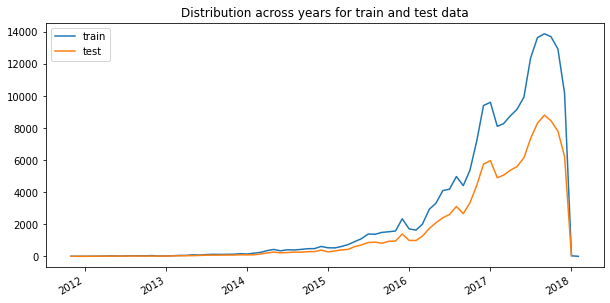

In [ ]:
#https://www.kaggle.com/tminima/elo-eda
'''
getting the number of transactions for every year both train and test separately
so that we can plot the distribution of values for train and test data.
'''
labels=['train','test']
temp = train.first_active_month.value_counts().sort_index()
temp1 = test.first_active_month.value_counts().sort_index()
ax = temp.plot(figsize=(10, 5))
ax = temp1.plot(figsize=(10,5))
ax.set_title("Distribution across years for train and test data")
ax.legend(labels)

###2.1 Merchant data Overview:

In [ ]:
merchant_dic = pd.read_excel('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/Data_Dictionary.xlsx', sheet_name='merchant')
merchant_dic

,merchants.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,merchant_id,Unique merchant identifier
3,merchant_group_id,Merchant group (anonymized )
4,merchant_category_id,Unique identifier for merchant category (anony...
5,subsector_id,Merchant category group (anonymized )
6,numerical_1,anonymized measure
7,numerical_2,anonymized measure
8,category_1,anonymized category
9,most_recent_sales_range,Range of revenue (monetary units) in last acti...


In [ ]:
print("Shape of the merchant dataframe: ",merchants.shape)

Shape of the merchant dataframe:  (334696, 22)


In [ ]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [ ]:
print("Number of total merchant id's: ",merchants.merchant_id.shape)
print("Number of unique merchant id's: ",merchants.merchant_id.unique().shape)
print("Number of duplicate merchnt id's: ",merchants.merchant_id.shape[0]-merchants.merchant_id.unique().shape[0])

Number of total merchant id's:  (334696,)
Number of unique merchant id's:  (334633,)
Number of duplicate merchnt id's:  63


In [ ]:
duplicate_merchant=merchants.merchant_id.value_counts()
duplicate_merchant=duplicate_merchant[duplicate_merchant>1]
print(duplicate_merchant)
print("number of duplicate merchant id's: ",len(duplicate_merchant))

M_ID_992a180b15    4
M_ID_ebbdb42da6    4
M_ID_ef233cff26    4
M_ID_bd49e37dda    4
M_ID_30340088f2    4
M_ID_c2b9ac2ea4    4
M_ID_d123532c72    4
M_ID_dbbf07ebf0    4
M_ID_6464db3b45    4
M_ID_42697d5d44    4
M_ID_1802942aaf    4
M_ID_57e97f6546    2
M_ID_26d4fadb60    2
M_ID_49b779bc8a    2
M_ID_b794b9d9e8    2
M_ID_a8767b29ef    2
M_ID_0a00fa9e8a    2
M_ID_645a6af169    2
M_ID_0039220eb3    2
M_ID_c0b712e11a    2
M_ID_6017075769    2
M_ID_c470fbcfb9    2
M_ID_9b0ef314cf    2
M_ID_6c144405a0    2
M_ID_1ceca881f0    2
M_ID_508ecbdcde    2
M_ID_0b8ed0c2b0    2
M_ID_654509ddbc    2
M_ID_7483dde87d    2
M_ID_8951e22556    2
M_ID_07a5671b4c    2
M_ID_fea38c640b    2
M_ID_00a6ca8a8a    2
M_ID_0c4018d3a0    2
M_ID_49daf8a838    2
M_ID_ae9fe1605a    2
M_ID_7251df88ad    2
M_ID_a55beb9d9a    2
M_ID_d2b5d4418d    2
M_ID_32d73b8ecf    2
M_ID_28c2aace87    2
Name: merchant_id, dtype: int64
number of duplicate merchant id's:  41


In [ ]:
null_checks = merchants.isnull().sum()
null_info_df = pd.DataFrame({"nulls": null_checks, "null_percent": null_checks*100/merchants.shape[0]})
null_info_df

,nulls,null_percent
merchant_id,0,0.000000
merchant_group_id,0,0.000000
merchant_category_id,0,0.000000
subsector_id,0,0.000000
numerical_1,0,0.000000
numerical_2,0,0.000000
category_1,0,0.000000
most_recent_sales_range,0,0.000000
most_recent_purchases_range,0,0.000000
avg_sales_lag3,13,0.003884


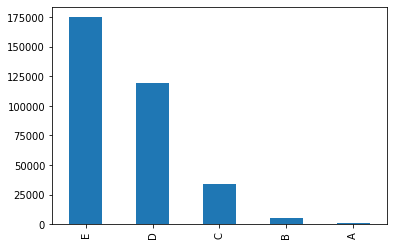

In [ ]:
merchants.most_recent_purchases_range.value_counts().plot(kind="bar")

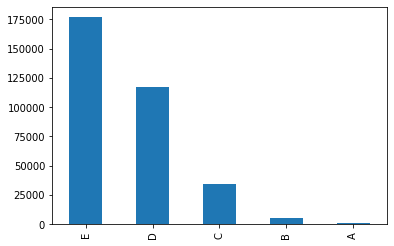

In [ ]:
merchants.most_recent_sales_range.value_counts().plot(kind="bar")

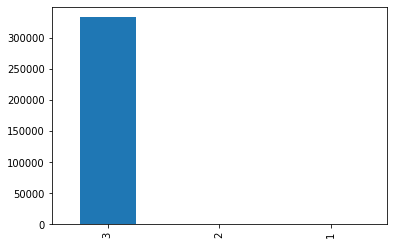

In [ ]:
merchants.active_months_lag3.value_counts().plot(kind="bar")

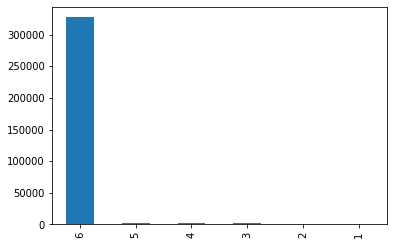

In [ ]:
merchants.active_months_lag6.value_counts().plot(kind="bar")

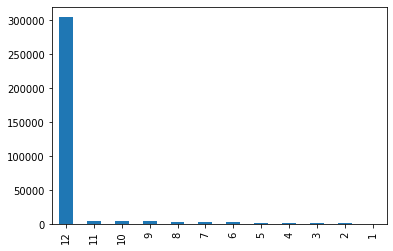

In [ ]:
merchants.active_months_lag12.value_counts().plot(kind="bar")

Observations:

1.There are total 41 merchant id's having count more than one and we can call it as duplicate.

2.We can remove the  duplicate by keeping single record for each merchant id and removing all other.

3.There are few columns having null values which we need to consider for imputing.

4.In the bar plot we can see that most recent purchase range and sales range are huge.

5.Active months lag are very high in the respective features

###2.2 New Merchant Transactions:


In [ ]:
new_merchant_transaction_dict = pd.read_excel('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/Data_Dictionary.xlsx', sheet_name='new_merchant_period')
new_merchant_transaction_dict

,new_merchant_period.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [ ]:
new_merchant_transctions.head() 

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [ ]:
print("Shape of the new merchant transaction is: ",new_merchant_transctions.shape)

Shape of the new merchant transaction is:  (1963031, 14)


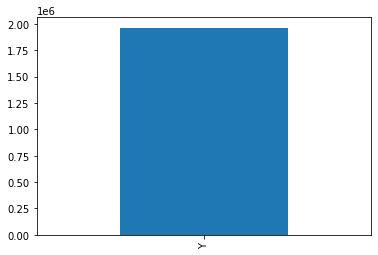

In [ ]:
new_merchant_transctions.authorized_flag.value_counts().plot(kind="bar")

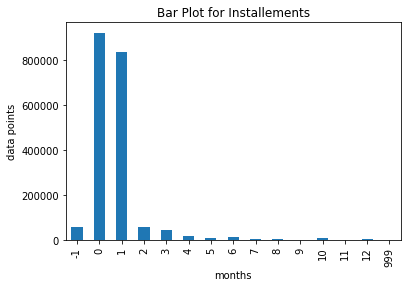

In [ ]:
x = sorted(new_merchant_transctions.installments.value_counts().index)
y = new_merchant_transctions.installments.value_counts()
y[x].plot(kind="bar",xlabel="months",ylabel="data points",title="Bar Plot for Installements")


In [ ]:
null_checks = new_merchant_transctions.isnull().sum()
null_info_df = pd.DataFrame({"nulls": null_checks, "null_percent": null_checks*100/new_merchant_transctions.shape[0]})
null_info_df

,nulls,null_percent
authorized_flag,0,0.000000
card_id,0,0.000000
city_id,0,0.000000
category_1,0,0.000000
installments,0,0.000000
category_3,55922,2.848758
merchant_category_id,0,0.000000
merchant_id,26216,1.335486
month_lag,0,0.000000
purchase_amount,0,0.000000


In [ ]:
new_merchant_transctions['new_weekofyear'] = new_merchant_transctions['purchase_date'].dt.weekofyear
new_merchant_transctions['new_weekday'] = new_merchant_transctions['purchase_date'].dt.weekday
new_merchant_transctions['new_weekend'] = (new_merchant_transctions['purchase_date'].dt.weekday >=5).astype(int)
new_merchant_transctions['new_month'] = new_merchant_transctions['purchase_date'].dt.month
new_merchant_transctions['new_day'] = new_merchant_transctions['purchase_date'].dt.day
new_merchant_transctions['new_hour'] = new_merchant_transctions['purchase_date'].dt.hour

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


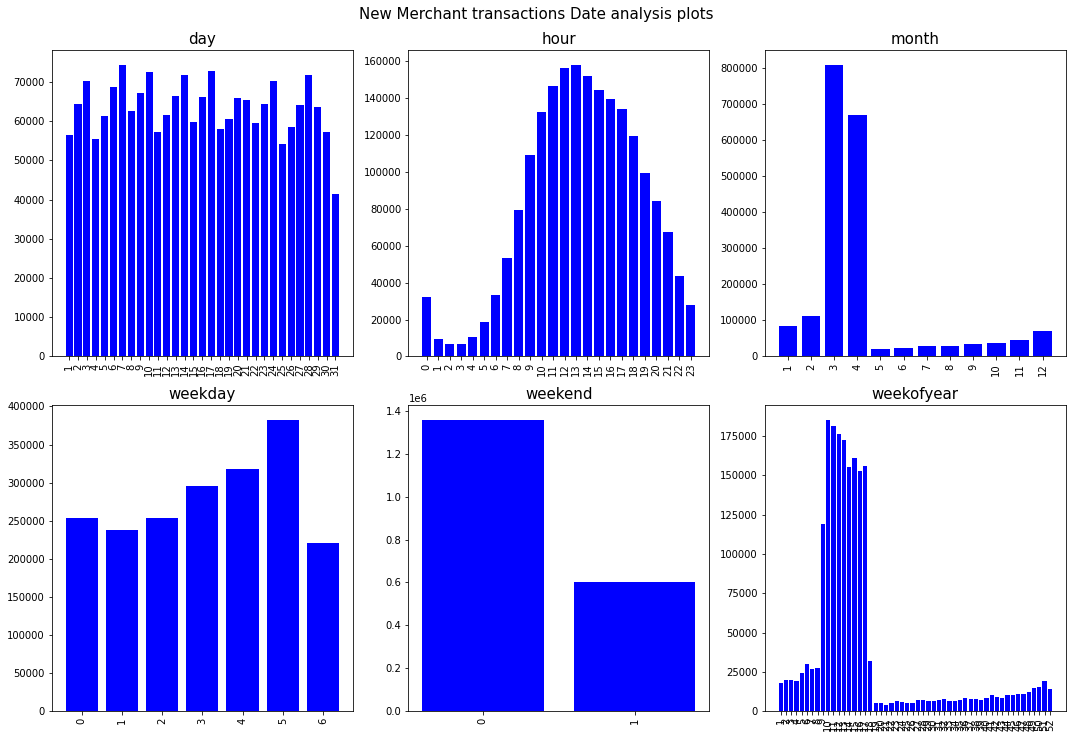

In [ ]:
#https://github.com/indgoddess/ELO_merchant_category/blob/main/ELO_EDA.ipynb
date_cols = ['weekofyear', 'weekday', 'weekend','month', 'day','hour']
plt.figure(figsize=[15, 10])
plt.suptitle('New Merchant transactions Date analysis plots', y=1.02, fontsize=15)
ncols = 3
nrows = int(np.ceil((len(date_cols)/3)))
last_ind = 0
for col in sorted(list(new_merchant_transctions.columns)):    
    if col in date_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = new_merchant_transctions[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color="blue")
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    
    plt.tight_layout()

Observations:

1.As we can see that all transactions are authorize and all values are "Y".we can remove this colummn as it is not having much significance on predicting loyalty score as all values are same.

2.Most of the purchase amount are in between 0-50 and there are few datapoints which are between 50-100 and seems few outliers which are gretter than 100.

3.Installments should be between 0-12 months,however we can see month value of -1 and 999 which may be some error or wrong entries.

4.There are 3 columns havinf null values,category_2,category_3 and merchant_id.We need to handle this by either imputaion or removal.

5.Users purchase more on Saturday than any other day, there are less purchase on end of the month,we found highest number of purchase in March and April month,Also found most of highest number of purchase between 9AM to 6PM

###3.1 History Merchant transaction

In [ ]:
historical_transactions_dict = pd.read_excel('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/Data_Dictionary.xlsx', sheet_name='history')
historical_transactions_dict

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [ ]:
print("Shape of the history transaction is: ",historical_transactions.shape)

Shape of the history transaction is:  (29112361, 14)


In [ ]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


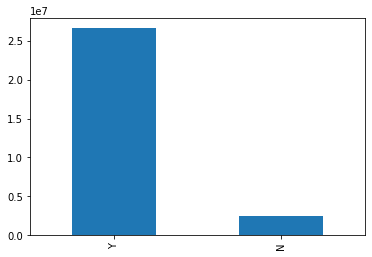

In [ ]:
historical_transactions.authorized_flag.value_counts().plot(kind="bar")

In [ ]:
null_checks = historical_transactions.isnull().sum()
null_info_df = pd.DataFrame({"nulls": null_checks, "null_percent": null_checks*100/historical_transactions.shape[0]})
null_info_df

,nulls,null_percent
authorized_flag,0,0.000000
card_id,0,0.000000
city_id,0,0.000000
category_1,0,0.000000
installments,0,0.000000
category_3,178159,0.611970
merchant_category_id,0,0.000000
merchant_id,138481,0.475678
month_lag,0,0.000000
purchase_amount,0,0.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


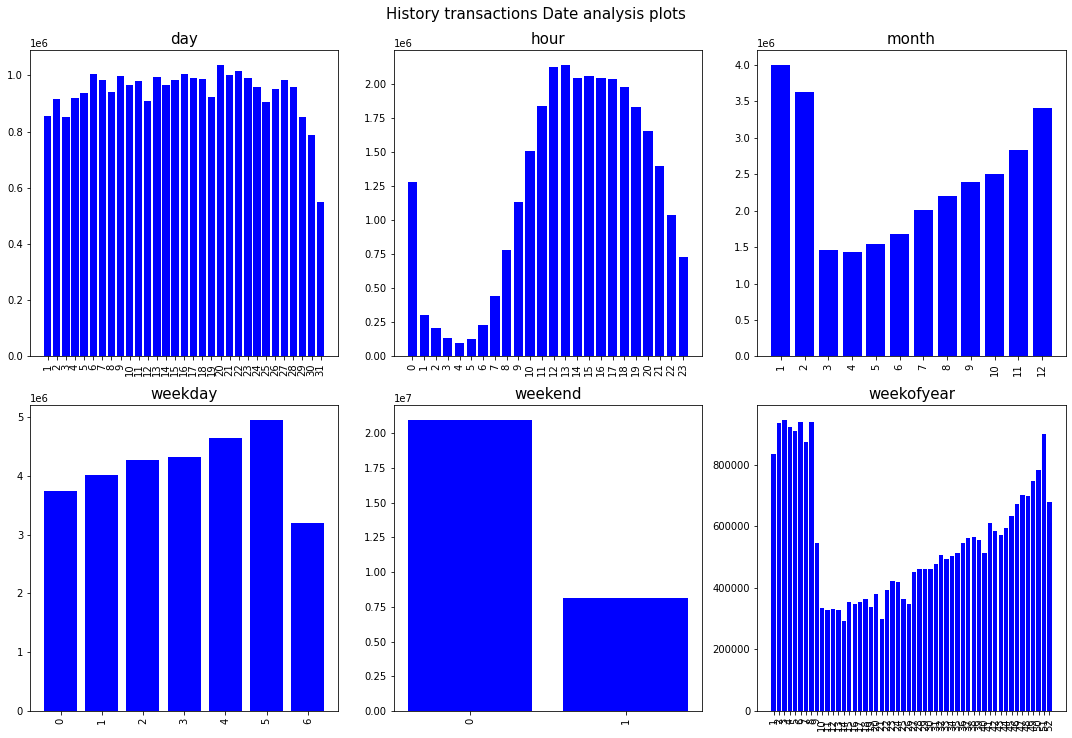

In [ ]:
#https://github.com/indgoddess/ELO_merchant_category/blob/main/ELO_EDA.ipynb
date_cols = ['weekofyear', 'weekday', 'weekend','month', 'day','hour']
plt.figure(figsize=[15, 10])
plt.suptitle('History transactions Date analysis plots', y=1.02, fontsize=15)
ncols = 3
nrows = int(np.ceil((len(date_cols)/3)))
last_ind = 0
for col in sorted(list(historical_transactions.columns)):    
    if col in date_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = historical_transactions[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color="blue")
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    
    plt.tight_layout()

Observations:

1.As compared the new merchant transaction data here in history transaction data we have unauthorize tranaction as well.We need to experiment if we can reomve these records or not.

2.Similar to new merchant transaction data,highest purchase made on Saturday.

3.Here highest purchase made in the month of Jan,Feb and Dec as in new merchant transation highest purchase made months are Mar and Apr.

##Summary till now:

1. At Very first we have analyze all the given data files and also load the data.

2. As in train data file we have very few features including given Loyalty Score,However we have other files for new and historical transactions which are providing transaction details which we need to utilize.

3. After loading the data we have perform basic analysis like, analysis on null values in features,duplicate datapoints, overlapping data points in train and test,analysis on outliers etc.

4. After basic analysis on the given data we have perofrm analysis on the distribution of data points,analyze the numerical,cetegorical features and there distribution.

5. We have engineered "target_class" response lable column in order to analyze the data for positive and negative loyalty score, which can also help in if we want to pose the problem as classification problem.

6. Once basic analysis has been done.We have perform univariate anlayis on the given features in train data as well as on the engineered fetures also shows violin plot for the categorical features in order to understand the categories distributed  with respect loyalty score.

7. As the train data having card details and transaction files having transaction details for the cards present in tarin data.We have engineered the new features by aggregating the records present for cards in transaction details.

8. We have perform bivariate analysis on the alrady existing as well newly engineered aggregate features with respect to target variable loyalty score.We have used scatter plot to show bivariate analysis.

##Key takeaway:

1. There are no null values in train data except one null value for  feature "first_active_month" in test data which we can impute.

2. In transaction data we have null values for columns category_2, category_3 and merchant_id which needs to be imput or delete base on impact experimenting.

3. We have higher number of transactions between 2016 to 2018 year as compared to the previous years.

4. All the exsting as well as engineered aggregate features are almost independent of each other except few features.

5. In bivariate analysis we found many unique patterns for the data,however  the data points with positive and negative loyalty score are jumbled up whcih shows features are not  mostly corelated.

6. In Loyalty score distribution we can see there are almost 1% of data points are at -33 and these data points not seems to be outlier.

7. We can see more number of transactions between month Jan-Apr and on daily basis transaction happen between 8 AM to 8 PM also we can see that less transactions on Sunday.

8. There certain merchant id's which are duplicate and we need to either delete it by keeping only one copy or aggregate all the values with merchant id's.

9. Installments can not be 999 and -1 which needs to be impute with some other values as it seems to be error.


##Feature Engineering

In [ ]:
## Reference: https://medium.com/towards-artificial-intelligence/handling-missing-data-for-advanced-machine-learning-b6eb89050357

def model_imputation(data_frame, non_categorical_clmn, features_nan_value, models):
  '''This function perform model imputation for categorical columns having null values
     with specified algorithm'''
     
  tmp_storage = data_frame[non_categorical_clmn]
  data_frame.drop(non_categorical_clmn, axis=1, inplace=True)
  features_no_nan_values = [c for c in data_frame.columns if c not in features_nan_value]

  for feat in tqdm(features_nan_value):
    print(feat)
    df_null = data_frame[data_frame[feat].isna()]
    df_train = data_frame.dropna()
    clf = models[feat]
    clf.fit(df_train[features_no_nan_values], df_train[feat])     
    data_frame.loc[data_frame[feat].isna(), feat] = clf.predict(df_null[features_no_nan_values])
    data_frame[non_categorical_clmn] = tmp_storage[non_categorical_clmn]  
  del tmp_storage
  return data_frame

In [ ]:
new_merchant_transctions['category_1'] = new_merchant_transctions['category_1'].map({'Y':1, 'N':0})
new_merchant_transctions['category_3'] = new_merchant_transctions['category_3'].map({'A':1, 'B':2,'C':3})
new_merchant_transctions['authorized_flag'] = new_merchant_transctions['authorized_flag'].map({'Y':1, 'N':0})
historical_transactions['category_1'] = historical_transactions['category_1'].map({'Y':1, 'N':0})
historical_transactions['category_3'] = historical_transactions['category_3'].map({'A':1, 'B':2,'C':3})
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].map({'Y':1, 'N':0})

In [ ]:
non_categorical= ['card_id', 'merchant_id', 'purchase_date']
model_transacations = {'category_2':LogisticRegression(),'category_3':LogisticRegression() }

new_merchant_transctions =reduce_mem_usage(model_imputation(data_frame = new_merchant_transctions,
                                           non_categorical_clmn = non_categorical,
                                           features_nan_value =  ['category_2', 'category_3'],
                                           models = model_transacations))

  0%|          | 0/2 [00:00<?, ?it/s]

category_2


 50%|█████     | 1/2 [01:30<01:30, 90.56s/it]

category_3


100%|██████████| 2/2 [02:46<00:00, 83.06s/it]


Mem. usage decreased to 76.76 Mb (32.8% reduction)


In [ ]:
#new_merchant_transctions.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/new_merchant_transctions_model_imputed.csv",index=False)
new_merchant_transctions=reduce_mem_usage(pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/new_merchant_transctions_model_imputed.csv",parse_dates=['purchase_date']))
gc.collect()

Mem. usage decreased to 76.76 Mb (63.4% reduction)


67

In [ ]:
non_categorical= ['card_id', 'merchant_id', 'purchase_date']
model_transacations = {'category_2':LogisticRegression(),'category_3':LogisticRegression() }

historical_transactions =reduce_mem_usage(model_imputation(data_frame = historical_transactions,
                                          non_categorical_clmn = non_categorical,
                                          features_nan_value =  ['category_2', 'category_3'],
                                          models = model_transacations))



  0%|          | 0/2 [00:00<?, ?it/s]

category_2


 50%|█████     | 1/2 [20:45<20:45, 1245.59s/it]

category_3


100%|██████████| 2/2 [39:08<00:00, 1174.29s/it]


Mem. usage decreased to 1193.84 Mb (31.7% reduction)


In [ ]:
#historical_transactions.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/historical_transactions_model_imputed.csv",index=False)
historical_transactions=reduce_mem_usage(pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/historical_transactions_model_imputed.csv",parse_dates=['purchase_date']))
gc.collect()

Mem. usage decreased to 1193.84 Mb (61.6% reduction)


0

In [ ]:
from tqdm import tqdm
def oneHotEncoding(df, features):
'''This function helps created one hot encoded features for given column'''

  for feat in tqdm(features):
    unique_values = df[feat].unique()

    for cat in unique_values:
      df[feat+'={}'.format(cat)] = (df[feat] == cat).astype(int)

In [ ]:
#Features for one-hot encoding 
categorical_features = ['category_2','category_3','month_lag']

#historical transactions one-hot feature encoding 
oneHotEncoding(historical_transactions, features=categorical_features)

#new merchants transactions one-hot feature encoding
oneHotEncoding(new_merchant_transctions, features=categorical_features)

gc.collect()

100%|██████████| 3/3 [00:00<00:00,  7.51it/s]


52

In [ ]:
def transactions_data_conversion():
  '''This function performing some basic data conversion'''
  
  ## reference: https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights
  new_merchant_transctions['purchase_amount'] = np.round(new_merchant_transctions['purchase_amount'] / 0.00150265118 + 497.06, 2)
  historical_transactions['purchase_amount'] = np.round(historical_transactions['purchase_amount'] / 0.00150265118 + 497.06, 2)

  for df in [historical_transactions,new_merchant_transctions]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['day']=df['purchase_date'].dt.day
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['installments']=df['installments'].map({-1:14, 0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:9,10:10,11:11,12:12,999:13})
    df['price']=df['purchase_amount']/df['installments']
    df['purchase_amount_quantiles']= pd.qcut(df['purchase_amount'], 5, labels=False)
    df['installments_quantiles']= pd.qcut(df['installments'], 5, labels=False,duplicates='drop')
    df['amount_month_ratio'] = df['purchase_amount'].values / (1.0 + df['month_diff'].values)


#transactions_data_conversion()
gc.collect()

26

In [ ]:
historical_transactions=reduce_mem_usage(historical_transactions)
new_merchant_transctions=reduce_mem_usage(new_merchant_transctions)
gc.collect()

Mem. usage decreased to 2415.44 Mb (73.2% reduction)
Mem. usage decreased to 155.38 Mb (62.8% reduction)


0

In [ ]:
holidays = {'EasterDay_2017' : '2017-04-16','AllSoulsDay_2017': '2017-11-2','ChristmasDay_2017': '2017-12-25','FathersDay_2017': '2017-08-13',
            'ChildrenDay_2017':'2017-10-12','BlackFriday_2017':'2017-11-24','ValentineDay_2017':'2017-06-12','MothersDay_2018':'2018-05-13'}

## we are gonna represent number days as the feature. if the values is above 30 then it will become zero.
def holidays_features():
  '''This function helps create holidays features'''
  
  for day, date in holidays.items():
    new_merchant_transctions[day] = (pd.to_datetime(date) - new_merchant_transctions['purchase_date']).dt.days
    new_merchant_transctions[day] = new_merchant_transctions[day].apply(lambda x: x if x > 0 and x < 30 else 0)
    historical_transactions[day] = (pd.to_datetime(date) - historical_transactions['purchase_date']).dt.days
    historical_transactions[day] = historical_transactions[day].apply(lambda x: x if x > 0 and x < 30 else 0)

#holidays_features()

In [ ]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [ ]:
def generate_hist_transac_agg_features(test,train,historical_transactions):
  '''This function helps create aggregate function as well as 
     features depend on aggregate features'''
     
  aggs = {}
  for col in ['month','hour','day','weekend','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id','price','city_id','state_id',
            'category_2=1.0', 'category_2=3.0', 'category_2=5.0',
            'category_2=2.0', 'category_2=4.0', 'category_3=1.0', 'category_3=2.0',
            'category_3=3.0', 'month_lag=-8', 'month_lag=-7', 'month_lag=-6',
            'month_lag=-5', 'month_lag=-11', 'month_lag=0', 'month_lag=-3',
            'month_lag=-9', 'month_lag=-4', 'month_lag=-1', 'month_lag=-13',
            'month_lag=-10', 'month_lag=-12', 'month_lag=-2']:
      aggs[col] = ['nunique']

  aggs['EasterDay_2017']=['sum', 'mean']
  aggs['AllSoulsDay_2017']=['sum', 'mean']
  aggs['ChristmasDay_2017']=['sum', 'mean']
  aggs['FathersDay_2017']=['sum', 'mean']
  aggs['ChildrenDay_2017']=['sum', 'mean']
  aggs['BlackFriday_2017']=['sum', 'mean']
  aggs['ValentineDay_2017']=['sum', 'mean']
  aggs['MothersDay_2018']=['sum', 'mean']

  aggs['category_2=1.0']=['sum', 'mean']
  aggs['category_2=3.0']=['sum', 'mean']
  aggs['category_2=2.0']=['sum', 'mean']
  aggs['category_2=4.0']=['sum', 'mean']
  aggs['category_2=5.0']=['sum', 'mean']
  aggs['category_3=1.0']=['sum', 'mean']
  aggs['category_3=2.0']=['sum', 'mean']
  aggs['category_3=3.0']=['sum', 'mean']

  aggs['month_lag=0']= ['sum','mean']
  aggs['month_lag=-1']=['sum','mean']
  aggs['month_lag=-2']=['sum','mean']

  aggs['purchase_amount'] = ['sum','max','min','mean','var']
  aggs['installments'] = ['sum','max','min','mean','var','std','skew']
  aggs['purchase_date'] = ['max','min']
  aggs['month_lag'] = ['mean', 'std', 'min', 'max', 'skew']
  aggs['month_diff'] = ['mean']
  aggs['authorized_flag'] = ['sum', 'mean']
  aggs['weekend'] = ['sum', 'mean']
  aggs['category_1'] = ['sum', 'mean']
  aggs['card_id'] = ['size']
  aggs['installments_quantiles']=['var', 'mean', 'skew']
  aggs['purchase_amount_quantiles']=['var', 'mean', 'skew']
  aggs['amount_month_ratio']=['mean', 'std', 'min', 'max', 'skew']
  #aggs['price'] = ['sum', 'mean']  
  aggs['weekofyear']=['mean', 'min', 'max']
  aggs['dayofweek']=['mean', 'min', 'max']
  aggs['hour']=['mean', 'min', 'max']  
    
  new_columns = get_new_columns('hist',aggs)
  df_hist_trans_group = historical_transactions.groupby('card_id').agg(aggs)
  df_hist_trans_group.columns = new_columns
  df_hist_trans_group.reset_index(drop=False,inplace=True)

  df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
  df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
  df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
  df_hist_trans_group['hist_of_hist_purchase_date_average']=df_hist_trans_group['hist_purchase_date_diff']*df_hist_trans_group['hist_purchase_date_average']

  #Newly added features
  df_hist_trans_group['hist_purchase_amount_diff'] = df_hist_trans_group['hist_purchase_amount_max'].values - df_hist_trans_group['hist_purchase_amount_min'].values
  df_hist_trans_group['hist_purchase_count_ratio'] = df_hist_trans_group['hist_card_id_size'].values / (1.0 + df_hist_trans_group['hist_purchase_date_diff'].values)
  df_hist_trans_group['hist_purchase_recency'] = (datetime.datetime.today() - pd.to_datetime(df_hist_trans_group['hist_purchase_date_max']))/(24*np.timedelta64(1, 'h'))

  df_hist_trans_group['hist_category_2_pa_mean'] = historical_transactions.groupby('category_2')['purchase_amount'].transform('mean')
  df_hist_trans_group['hist_category_3_pa_mean'] = historical_transactions.groupby('category_3')['purchase_amount'].transform('mean')

  df_hist_trans_group['hist_merchant_id_count_mean'] = df_hist_trans_group['hist_card_id_size'].values / (1.0+df_hist_trans_group['hist_merchant_id_nunique'].values)
  df_hist_trans_group['hist_month_lag_0_-1_ratio'] = df_hist_trans_group['hist_month_lag=0_sum']/ (1.0+ df_hist_trans_group['hist_month_lag=-1_sum'])
  df_hist_trans_group['hist_month_lag_0_-2_ratio'] = df_hist_trans_group['hist_month_lag=0_sum'] / (1.0+ df_hist_trans_group['hist_month_lag=-2_sum'])

  train = train.merge(df_hist_trans_group,on='card_id',how='left')
  test = test.merge(df_hist_trans_group,on='card_id',how='left')
  del df_hist_trans_group
  gc.collect()
  return test,train,historical_transactions

In [ ]:
def generate_new_transac_agg_features(test,train,new_merchant_transctions):
   '''This function helps create aggregate function as well as 
     features depend on aggregate features'''
     
  aggs = {}
  for col in ['month','hour','day','weekend','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id','price','city_id','state_id',
            'category_2=1.0', 'category_2=3.0', 'category_2=2.0',
            'category_2=4.0', 'category_2=5.0', 'category_3=2.0', 'category_3=1.0',
            'category_3=3.0', 'month_lag=1', 'month_lag=2']:
      aggs[col] = ['nunique']

  aggs['EasterDay_2017']=['sum', 'mean']
  aggs['AllSoulsDay_2017']=['sum', 'mean']
  aggs['ChristmasDay_2017']=['sum', 'mean']
  aggs['FathersDay_2017']=['sum', 'mean']
  aggs['ChildrenDay_2017']=['sum', 'mean']
  aggs['BlackFriday_2017']=['sum', 'mean']
  aggs['ValentineDay_2017']=['sum', 'mean']
  aggs['MothersDay_2018']=['sum', 'mean']

  aggs['category_2=1.0']=['sum', 'mean']
  aggs['category_2=3.0']=['sum', 'mean']
  aggs['category_2=2.0']=['sum', 'mean']
  aggs['category_2=4.0']=['sum', 'mean']
  aggs['category_2=5.0']=['sum', 'mean']
  aggs['category_3=1.0']=['sum', 'mean']
  aggs['category_3=2.0']=['sum', 'mean']
  aggs['category_3=3.0']=['sum', 'mean']

  aggs['month_lag=1']= ['sum','mean']
  aggs['month_lag=2']=['sum','mean']

  aggs['purchase_amount'] = ['sum','max','min','mean','var']
  aggs['installments'] = ['sum','max','min','mean','var','std','skew']
  aggs['purchase_date'] = ['max','min']
  aggs['month_lag'] = ['mean', 'std', 'min', 'max', 'skew']
  aggs['month_diff'] = ['mean']
  aggs['authorized_flag'] = ['sum', 'mean']
  aggs['weekend'] = ['sum', 'mean']
  aggs['category_1'] = ['sum', 'mean']
  aggs['card_id'] = ['size']
  aggs['installments_quantiles']=['var', 'mean', 'skew']
  aggs['purchase_amount_quantiles']=['var', 'mean', 'skew']
  #aggs['price'] = ['sum', 'mean']
  aggs['weekofyear']=['mean', 'min', 'max']
  aggs['dayofweek']=['mean', 'min', 'max']
  aggs['hour']=['mean', 'min', 'max']

  new_columns = get_new_columns('new_hist',aggs)
  df_hist_trans_group = new_merchant_transctions.groupby('card_id').agg(aggs)
  df_hist_trans_group.columns = new_columns
  df_hist_trans_group.reset_index(drop=False,inplace=True)
  df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
  df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
  df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
  df_hist_trans_group['new_hist_of_new_hist_purchase_date_average']=df_hist_trans_group['new_hist_purchase_date_diff']*df_hist_trans_group['new_hist_purchase_date_average']

  #newly added fature
  df_hist_trans_group['new_hist_purchase_amount_diff'] = df_hist_trans_group['new_hist_purchase_amount_max'].values - df_hist_trans_group['new_hist_purchase_amount_min'].values
  df_hist_trans_group['new_hist_purchase_count_ratio'] = df_hist_trans_group['new_hist_card_id_size'].values / (1.0 + df_hist_trans_group['new_hist_purchase_date_diff'].values)
  df_hist_trans_group['new_hist_purchase_recency'] = (datetime.datetime.today() - pd.to_datetime(df_hist_trans_group['new_hist_purchase_date_max']))/(24*np.timedelta64(1, 'h'))

  df_hist_trans_group['new_hist_category_2_pa_mean'] = historical_transactions.groupby('category_2')['purchase_amount'].transform('mean')
  df_hist_trans_group['new_hist_category_3_pa_mean'] = historical_transactions.groupby('category_3')['purchase_amount'].transform('mean')

  df_hist_trans_group['new_hist_merchant_id_count_mean'] = df_hist_trans_group['new_hist_card_id_size'].values / (1.0+df_hist_trans_group['new_hist_merchant_id_nunique'].values)
  df_hist_trans_group['new_hist_month_lag_1_2_ratio'] = df_hist_trans_group['new_hist_month_lag=1_sum'] / (1.0+ df_hist_trans_group['new_hist_month_lag=2_sum'])

  train = train.merge(df_hist_trans_group,on='card_id',how='left')
  test = test.merge(df_hist_trans_group,on='card_id',how='left')
  del df_hist_trans_group;
  gc.collect()
  return test,train,new_merchant_transctions

In [ ]:
def create_quantiles(train):
  ## qunatiles of RFM
  quantiles_new = train[['new_hist_purchase_recency','new_hist_card_id_size','new_hist_purchase_amount_sum']].quantile(q=[0.011,0.05,0.25,0.5,0.75,0.95,0.989]).to_dict()
  ## quantiles of RFM with historical transactions
  quantiles_hist = train[['hist_purchase_recency','hist_card_id_size','hist_purchase_amount_sum']].quantile(q=[0.011,0.05,0.25,0.5,0.75,0.95,0.989]).to_dict()
  
  return quantiles_new,quantiles_hist

quantiles_new,quantiles_hist=create_quantiles()

In [ ]:
## reference: https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6

def RScore(x,p,d):
    if x <= d[p][0.011]:
        return 1
    elif x <= d[p][0.050]:
        return 2
    elif x <= d[p][0.25]: 
        return 3
    elif x <= d[p][0.5]:
        return 4
    elif x <= d[p][0.75]:
        return 5
    elif x <= d[p][0.95]:
        return 6
    elif x <= d[p][0.989]:
        return 7
    else:
        return 8
    
def FMScore(x,p,d):
    if x <= d[p][0.011]:
        return 8
    elif x <= d[p][0.050]:
        return 7
    elif x <= d[p][0.25]: 
        return 6
    elif x <= d[p][0.5]:
        return 5
    elif x <= d[p][0.75]:
        return 4
    elif x <= d[p][0.95]:
        return 3
    elif x <= d[p][0.989]:
        return 2
    else:
        return 1

In [ ]:
def rfm(df,quantiles, transc):
  ## grouping quantiles
  df[transc+'r_quantile'] = df[transc+'purchase_recency'].apply(RScore, args=(transc+'purchase_recency',quantiles))
  df[transc+'f_quantile'] = df[transc+'card_id_size'].apply(FMScore, args=(transc+'card_id_size',quantiles))
  df[transc+'m_quantile'] = df[transc+'purchase_amount_sum'].apply(FMScore, args=(transc+'purchase_amount_sum',quantiles))
  ## calaculating RFM index and RFMScore
  df[transc+'RFMindex'] = df[transc+'r_quantile'].map(str)+df[transc+'f_quantile'].map(str)+df[transc+'m_quantile'].map(str)                       
  df[transc+'RFMScore'] = df[transc+'r_quantile']+df[transc+'f_quantile']+df[transc+'m_quantile']

In [ ]:
## RFM score calculation
def all_remaining_processing(train,test,quantiles_new,quantiles_hist):
  for df in [train,test]:
    rfm(df,quantiles_new,transc = 'new_hist_')
    rfm(df,quantiles_hist,transc = 'hist_')

  train["new_hist_RFMindex"]=train["new_hist_RFMindex"].map(int)
  train["hist_RFMindex"]=train["hist_RFMindex"].map(int)
  test["new_hist_RFMindex"]=test["new_hist_RFMindex"].map(int)
  test["hist_RFMindex"]=test["hist_RFMindex"].map(int)

  train['outliers'] = 0
  train.loc[train['target'] < -30, 'outliers'] = 1
  #train['outliers'].value_counts()

  for df in [train,test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['days_feature1'] = df['elapsed_time'] * df['feature_1']  

  for df in [train,test]:
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max','new_hist_purchase_date_min']:
      df[f] = df[f].fillna(df[f].mean())
      df[f] = df[f].astype(np.int64) * 1e-9
  
  for f in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([f])['outliers'].mean()
    train[f] = train[f].map(order_label)
    test[f] = test[f].map(order_label)

  return train,test
#all_remaining_processing()

##Second Part:

In [ ]:
#train.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/train_engineered_4_Jul_2021.csv",index=False)
#test.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/test_engineered_4_Jul_2021.csv",index=False)
train=reduce_mem_usage(pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/train_engineered_4_Jul_2021.csv"))
test=reduce_mem_usage(pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/test_engineered_4_Jul_2021.csv"))

Mem. usage decreased to 98.98 Mb (73.3% reduction)
Mem. usage decreased to 60.60 Mb (73.1% reduction)


In [ ]:
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Mem. usage decreased to 92.43 Mb (6.6% reduction)
Mem. usage decreased to 56.59 Mb (6.6% reduction)


In [ ]:
def get_columns(train,test):
  df_train_columns = [c for c in train.columns if c not in ['card_id', 'first_active_month', 'target', 'outliers']]
  df_test_columns = [c for c in test.columns if c not in ['card_id', 'first_active_month', 'target', 'outliers']]
  return df_train_columns,df_test_columns

df_train_columns,df_test_columns=get_columns(train,test)

In [ ]:
def fillup_null_inf_values(train,test,df_train_columns,df_test_columns):
  test['first_active_month'].fillna('2017-06-01',inplace=True)
  for col in df_train_columns:
    train[col].fillna(train[col].median(),inplace=True)

  for col in df_test_columns:
    test[col].fillna(test[col].median(),inplace=True)

  train = train.replace(np.inf, np.nan)
  test = test.replace(np.inf, np.nan)

  col=['new_hist_purchase_amount_sum','new_hist_purchase_amount_min','new_hist_purchase_amount_mean',
     'new_hist_purchase_amount_max','new_hist_purchase_amount_var','new_hist_purchase_amount_diff','purchase_amount_total']

  for c in col:
    train[c].fillna(train[c].median(),inplace=True)
    test[c].fillna(train[c].median(),inplace=True)
  return train,test
#fillup_null_inf_values(df_train_columns,df_test_columns) 

In [ ]:
null_checks = train.isnull().sum()
null_info_df = pd.DataFrame({"nulls": null_checks, "null_percent": null_checks*100/train.shape[0]})
null_info_df[null_info_df.nulls!=0]

,nulls,null_percent


In [ ]:
null_checks = test.isnull().sum()
null_info_df = pd.DataFrame({"nulls": null_checks, "null_percent": null_checks*100/test.shape[0]})
null_info_df[null_info_df.nulls!=0]

,nulls,null_percent


In [ ]:
null_checks =np.isinf(train[df_train_columns]).sum()
null_info_df = pd.DataFrame({"nulls": null_checks, "null_percent": null_checks*100/train.shape[0]})
null_info_df[null_info_df.nulls!=0]

,nulls,null_percent


In [ ]:
null_checks =np.isinf(test[df_train_columns]).sum()
null_info_df = pd.DataFrame({"nulls": null_checks, "null_percent": null_checks*100/test.shape[0]})
null_info_df[null_info_df.nulls!=0]

,nulls,null_percent


In [ ]:
#definind the rmse metric
import keras.backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
y = train['target']
X = train[df_train_columns]#.drop(['target'], axis=1)

X_train_all, X_test_com, y_train_all, y_test_com = train_test_split(X, y, test_size=0.20, random_state=42)
print("X_train_all, X_test_com, y_train_all, y_test_com shape:",X_train_all.shape, X_test_com.shape, y_train_all.shape, y_test_com.shape)

#X_train_com, X_val_com, y_train_com, y_val_com = train_test_split(X_train_all, y_train_all, test_size=0.20, random_state=42)
#print("X_train_com, X_val_com, y_train_com, y_val_com shape:",X_train_com.shape, X_val_com.shape, y_train_com.shape, y_val_com.shape)


X_train_all, X_test_com, y_train_all, y_test_com shape: (161533, 237) (40384, 237) (161533,) (40384,)


##Linear Regression

In [ ]:

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train_all, y_train_all) #training the algorithm
y_pred_linear = regressor.predict(X_test_com)
print("RMSE using linear regression::{:.3f}".format(rmse(y_test_com, y_pred_linear)))
linear_test_pred=regressor.predict(test[df_test_columns])
#print("RMSE using linear regression for submission file::{:.3f}".format(rmse(y_test_com, test_pred)))

RMSE using linear regression::3.876


In [ ]:
submission_linear=pd.concat([test['card_id'], pd.Series(linear_test_pred)], axis = 1)
submission_linear.isnull().sum()

card_id    0
0          0
dtype: int64

In [ ]:
submission_linear=pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_linear.csv")
#submission_linear.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_linear.csv", index=False)
submission_linear

,card_id,0
0,C_ID_0ab67a22ab,-0.392713
1,C_ID_130fd0cbdd,-0.392715
2,C_ID_b709037bc5,-0.392713
3,C_ID_d27d835a9f,-0.392712
4,C_ID_2b5e3df5c2,-0.392716
...,...,...
123618,C_ID_7a239d2eda,-0.392716
123619,C_ID_75ace375ae,-0.392710
123620,C_ID_21d56d950c,-0.392717
123621,C_ID_6c46fc5a9d,-0.392715


##Ridge

In [ ]:
from sklearn.linear_model import Ridge 
ridge = Ridge()

parameters={'alpha': [1e-3,1e-2,1e-4]} 
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_root_mean_squared_error',cv=5) 
ridge_regressor.fit(X_train_all, y_train_all) 
y_pred_ridge = ridge_regressor.predict(X_test_com)
print("RMSE using ridge regression::{:.3f}".format(rmse(y_test_com, y_pred_ridge)))
ridge_test_pred=ridge_regressor.predict(test[df_test_columns])

RMSE using ridge regression::3.789


In [ ]:
submission_ridge=pd.concat([test['card_id'], pd.Series(ridge_test_pred)], axis = 1)
submission_ridge.isnull().sum()

card_id    0
0          0
dtype: int64

In [ ]:
submission_ridge=pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_ridge.csv")
#submission_ridge.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_ridge.csv", index=False)
submission_ridge

,card_id,0
0,C_ID_0ab67a22ab,-1.879492
1,C_ID_130fd0cbdd,-0.220444
2,C_ID_b709037bc5,-1.077492
3,C_ID_d27d835a9f,-0.076660
4,C_ID_2b5e3df5c2,-3.105564
...,...,...
123618,C_ID_7a239d2eda,0.161633
123619,C_ID_75ace375ae,0.813190
123620,C_ID_21d56d950c,0.346222
123621,C_ID_6c46fc5a9d,-2.320689


##Lasso

In [ ]:
from sklearn.linear_model import Lasso 

lasso = Lasso() 
parameters={'alpha':[1e-3,1e-2,1e-1], 'max_iter':[1000,2000]} 
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_root_mean_squared_error',cv=5)
lasso_regressor.fit(X_train_all, y_train_all) 
y_pred_lasso = lasso_regressor.predict(X_test_com) 
print("RMSE for Lasso Regressor::{:.3f}".format(rmse(y_test_com, y_pred_lasso)))
lasso_test_pred=lasso_regressor.predict(test[df_test_columns])

RMSE for Lasso Regressor::3.789


In [ ]:
submission_lasso=pd.concat([test['card_id'], pd.Series(lasso_test_pred)], axis = 1)
submission_lasso.isnull().sum()

card_id    0
0          0
dtype: int64

In [ ]:
submission_lasso=pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_lasso.csv")
#submission_lasso.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_lasso.csv", index=False)
submission_lasso

,card_id,0
0,C_ID_0ab67a22ab,-1.871836
1,C_ID_130fd0cbdd,-0.245694
2,C_ID_b709037bc5,-0.992889
3,C_ID_d27d835a9f,-0.069776
4,C_ID_2b5e3df5c2,-3.040103
...,...,...
123618,C_ID_7a239d2eda,0.158656
123619,C_ID_75ace375ae,0.820663
123620,C_ID_21d56d950c,0.354924
123621,C_ID_6c46fc5a9d,-2.314395


##Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
treeRegressor = DecisionTreeRegressor()

param_grid = {"criterion": ["mse"],"max_depth": [5,10,15], "min_samples_split": [8,10,15], "max_leaf_nodes": [10,15], "max_features": [25,50,100,500], "min_impurity_decrease":[0.1] } 
grid_decision = GridSearchCV(treeRegressor, param_grid, cv=5,verbose=1,n_jobs=-1) 
grid_decision.fit(X_train_all, y_train_all) 
y_pred_decision = grid_decision.predict(X_test_com)
print("RMSE for Decision Tree Regressor::{:.3f}".format(rmse(y_test_com, y_pred_decision)))
decision_tree_test_pred=grid_decision.predict(test[df_test_columns])

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.9min finished


RMSE for Decision Tree Regressor::3.807


In [ ]:
submission_decision_tree=pd.concat([test['card_id'], pd.Series(decision_tree_test_pred)], axis = 1)
submission_decision_tree.isnull().sum()

card_id    0
0          0
dtype: int64

In [ ]:
submission_decision_tree=pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_decision_tree.csv")
#submission_decision_tree.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_decision_tree.csv", index=False)
submission_decision_tree

,card_id,0
0,C_ID_0ab67a22ab,-4.119941
1,C_ID_130fd0cbdd,-0.091599
2,C_ID_b709037bc5,-0.091599
3,C_ID_d27d835a9f,-0.091599
4,C_ID_2b5e3df5c2,-0.091599
...,...,...
123618,C_ID_7a239d2eda,-0.091599
123619,C_ID_75ace375ae,-0.091599
123620,C_ID_21d56d950c,-0.091599
123621,C_ID_6c46fc5a9d,-1.121421


##Random Forest Regressor

In [ ]:

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,BaggingRegressor 
param_grid = {"criterion": ["mse"], 'n_estimators': [500,1000], "max_depth": [5,10,15], "max_leaf_nodes" : [5], "min_samples_split":[8] , "max_features": [50,100], "min_impurity_decrease":[0.1] } 
forestRegressor = RandomForestRegressor(random_state = 10)

grid_forest = GridSearchCV(forestRegressor, param_grid, cv=2, verbose=1,n_jobs=-1) 
grid_forest.fit(X_train_all, y_train_all)
y_pred_forest = grid_forest.predict(X_test_com)
print("RMSE for Random Forest Regressor::{:.3f}".format(rmse(y_test_com, y_pred_forest)))
random_forest_test_pred=grid_forest.predict(test[df_test_columns])

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 39.1min finished


RMSE for Random Forest Regressor::3.793


In [ ]:
submission_random_forest=pd.concat([test['card_id'], pd.Series(random_forest_test_pred)], axis = 1)
submission_random_forest.isnull().sum()

card_id    0
0          0
dtype: int64

In [ ]:
submission_random_forest=pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_random_forest.csv")
#submission_random_forest.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_random_forest.csv", index=False)
submission_random_forest

,card_id,0
0,C_ID_0ab67a22ab,-3.482852
1,C_ID_130fd0cbdd,-0.106239
2,C_ID_b709037bc5,-0.106239
3,C_ID_d27d835a9f,-0.106239
4,C_ID_2b5e3df5c2,-0.106239
...,...,...
123618,C_ID_7a239d2eda,-0.106239
123619,C_ID_75ace375ae,-0.106239
123620,C_ID_21d56d950c,-0.106239
123621,C_ID_6c46fc5a9d,-1.220026


##XGBRegressor

In [ ]:
import timeit
from xgboost import XGBRegressor
start = timeit.default_timer()
xgb = XGBRegressor() 
parameters = { 'gamma': [8], 'eval_metric' :['rmse'],'eta': [0.5], 'colsample_bytree':[0.3], 'min_child_weight': [3], 'max_depth' :[3,5,10], 'max_features':[50,100],'subsample': [0.7],'tree_method':['auto'], 'reg_alpha':[1000], "criterion": ["mse"],'n_estimators': [500,1000] ,'seed':[11] }

grid_xgb = GridSearchCV(xgb, parameters, cv = 3, n_jobs = -1, verbose=1) 
grid_xgb.fit(X_train_all, y_train_all) 
y_pred_xgb = grid_xgb.predict(X_test_com)

stop = timeit.default_timer()
execution_time = (stop - start)/60 
print("Ensemble Executed in {} minutes".format(str(execution_time)))
print("RMSE for XG Boost Regressor::{:.3f}".format(rmse(y_test_com, y_pred_xgb)))
xgbregressor_test_pred=grid_xgb.predict(test[df_test_columns])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 86.2min finished


[15:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Ensemble Executed in 92.74498806536666 minutes
RMSE for XG Boost Regressor::3.693


In [ ]:
submission_xgb_regressor=pd.concat([test['card_id'], pd.Series(xgbregressor_test_pred)], axis = 1)
submission_xgb_regressor.isnull().sum()

card_id    0
0          0
dtype: int64

In [ ]:
submission_xgb_regressor=pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_xgb_regressor.csv")
#submission_xgb_regressor.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_xgb_regressor.csv", index=False)
submission_xgb_regressor

,card_id,0
0,C_ID_0ab67a22ab,-4.752510
1,C_ID_130fd0cbdd,-0.225492
2,C_ID_b709037bc5,-1.457022
3,C_ID_d27d835a9f,-0.171168
4,C_ID_2b5e3df5c2,-1.294330
...,...,...
123618,C_ID_7a239d2eda,0.473096
123619,C_ID_75ace375ae,-0.580401
123620,C_ID_21d56d950c,0.255688
123621,C_ID_6c46fc5a9d,-3.832171


##AdaBoostRegressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor 
param = { 'n_estimators':[50], 'learning_rate':[1e-2], 'loss':['exponential'] } 
adaRegressor = AdaBoostRegressor(random_state = 10)

grid_ada = GridSearchCV(adaRegressor, param, cv = 3, n_jobs = -1, verbose=1) 
grid_ada.fit(X_train_all, y_train_all) 
y_pred_ada = grid_ada.predict(X_test_com)
print("RMSE for Ada Boost Regressor::{:.3f}".format(rmse(y_test_com, y_pred_ada)))
adaboostregressor_test_pred=grid_ada.predict(test[df_test_columns])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.7min finished


RMSE for Ada Boost Regressor::3.771


In [ ]:
submission_adaboost_regressor=pd.concat([test['card_id'], pd.Series(adaboostregressor_test_pred)], axis = 1)
submission_adaboost_regressor.isnull().sum()

card_id    0
0          0
dtype: int64

In [ ]:
submission_adaboost_regressor=pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_adaboost_regressor.csv")
#submission_adaboost_regressor.to_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_adaboost_regressor.csv", index=False)
submission_adaboost_regressor

,card_id,0
0,C_ID_0ab67a22ab,-6.394568
1,C_ID_130fd0cbdd,-0.177936
2,C_ID_b709037bc5,-0.780456
3,C_ID_d27d835a9f,-0.177936
4,C_ID_2b5e3df5c2,-0.688927
...,...,...
123618,C_ID_7a239d2eda,-0.683014
123619,C_ID_75ace375ae,-0.177936
123620,C_ID_21d56d950c,-0.683014
123621,C_ID_6c46fc5a9d,-0.777348


##LightGBM

In [ ]:
##splitting train and target values
y_train = train['target']
X = train.drop(['target'],axis=1)
outliers = X['outliers']
X_train = X.drop(['outliers'],axis = 1)
X_train=X_train[df_train_columns]

In [ ]:
## Reference https://github.com/optuna/optuna/blob/master/examples/lightgbm_simple.py
def objective(trial):
  ## defining the params to hypertune and other neccessary parameters 
    params = {
              'objective': 'regression', 'metric': 'rmse','verbose': -1,  "learning_rate": 0.01,'device': 'cpu',  'seed': 326,
              'boosting_type': 'gbdt', 'n_jobs': -1,'num_leaves': trial.suggest_int('num_leaves', 16, 64), 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.001, 1),
              'subsample': trial.suggest_uniform('subsample', 0.001, 1), 'max_depth': trial.suggest_int('max_depth', 1, 12),
              'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 10), 'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 10),
              'min_split_gain': trial.suggest_uniform('min_split_gain', 0, 10), 'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 45),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 16, 64)
              }

    ## definfing the dataset into the lgb model 
    lgb_model = lightgbm.Dataset(X_train, y_train, free_raw_data=False)
    ## creating folds so, training and validation can be done in folds of data
    folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    ## Intializing the regressor for cross vlidation 
    reg = lightgbm.cv(params=params, train_set=lgb_model,
                      metrics=['rmse'], nfold=3,
                      folds=folds.split(X_train, outliers.values),
                      num_boost_round=10000,
                      early_stopping_rounds=200, 
                      verbose_eval=False, seed=47)
    gc.collect()
    ## returning last rmse mean value 
    return reg['rmse-mean'][-1]

In [ ]:
## reference : https://colab.research.google.com/drive/1I8abciKFXBxkoXrcwLiG7_BrYskLnV8k#scrollTo=8lOM3b6iO3it

## This is a class build for using early stopping in optuna trails
OPTUNE_EARLY_STOPING = 20

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNE_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

In [ ]:
%%time
##  intializing the study to optimize
study = optuna.create_study()
## optimize to hyperparmeter tune.
try:
  study.optimize(objective, n_trials=20, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNE_EARLY_STOPING}')
gc.collect()

[I 2021-08-14 13:38:13,543] A new study created in memory with name: no-name-612b5dea-f5a3-4b5f-a835-76b06f787983
[I 2021-08-14 13:44:59,152] Trial 0 finished with value: 3.663694083770577 and parameters: {'num_leaves': 19, 'colsample_bytree': 0.9302995114537588, 'subsample': 0.10562839706329114, 'max_depth': 5, 'reg_alpha': 9.929328236068299, 'reg_lambda': 5.026309164933388, 'min_split_gain': 4.511870781609867, 'min_child_weight': 38.11331253299434, 'min_data_in_leaf': 21}. Best is trial 0 with value: 3.663694083770577.


EarlyStop counter: 1, Best score: 3.663694083770577 and 3.663694083770577


[I 2021-08-14 13:49:43,360] Trial 1 finished with value: 3.6587490268719023 and parameters: {'num_leaves': 20, 'colsample_bytree': 0.4939440489910636, 'subsample': 0.02076563710282164, 'max_depth': 11, 'reg_alpha': 8.133050369160998, 'reg_lambda': 2.5948375024665804, 'min_split_gain': 6.3930795763752934, 'min_child_weight': 1.4074899849883682, 'min_data_in_leaf': 57}. Best is trial 1 with value: 3.6587490268719023.


EarlyStop counter: 0, Best score: 3.6587490268719023 and 3.6587490268719023


[I 2021-08-14 14:10:16,173] Trial 2 finished with value: 3.687959119856778 and parameters: {'num_leaves': 38, 'colsample_bytree': 0.9046234666718862, 'subsample': 0.10384038534598616, 'max_depth': 2, 'reg_alpha': 3.5265968525346922, 'reg_lambda': 1.4050937768253569, 'min_split_gain': 8.910050204646515, 'min_child_weight': 9.782504814456397, 'min_data_in_leaf': 34}. Best is trial 1 with value: 3.6587490268719023.


EarlyStop counter: 1, Best score: 3.6587490268719023 and 3.6587490268719023


[I 2021-08-14 14:17:20,482] Trial 3 finished with value: 3.6674130324512224 and parameters: {'num_leaves': 41, 'colsample_bytree': 0.9718147691675358, 'subsample': 0.5058655194455296, 'max_depth': 4, 'reg_alpha': 0.5101247555714317, 'reg_lambda': 5.779783526684085, 'min_split_gain': 2.3108700570560003, 'min_child_weight': 42.498360054615446, 'min_data_in_leaf': 55}. Best is trial 1 with value: 3.6587490268719023.


EarlyStop counter: 2, Best score: 3.6587490268719023 and 3.6587490268719023


[I 2021-08-14 14:21:08,210] Trial 4 finished with value: 3.6585238089799876 and parameters: {'num_leaves': 31, 'colsample_bytree': 0.4082459277048223, 'subsample': 0.6240120647180766, 'max_depth': 6, 'reg_alpha': 9.546238510819009, 'reg_lambda': 5.205024939764532, 'min_split_gain': 5.856327205665939, 'min_child_weight': 3.0983824112742435, 'min_data_in_leaf': 22}. Best is trial 4 with value: 3.6585238089799876.


EarlyStop counter: 0, Best score: 3.6585238089799876 and 3.6585238089799876


[I 2021-08-14 14:30:42,091] Trial 5 finished with value: 3.6870898604488858 and parameters: {'num_leaves': 26, 'colsample_bytree': 0.29199592200543095, 'subsample': 0.7555936992497457, 'max_depth': 2, 'reg_alpha': 7.714745399514631, 'reg_lambda': 3.1692410102801825, 'min_split_gain': 9.680539372473598, 'min_child_weight': 5.837981317846612, 'min_data_in_leaf': 16}. Best is trial 4 with value: 3.6585238089799876.


EarlyStop counter: 1, Best score: 3.6585238089799876 and 3.6585238089799876


[I 2021-08-14 14:34:27,441] Trial 6 finished with value: 3.6567301111928097 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.3953011948177499, 'subsample': 0.7351553072789899, 'max_depth': 7, 'reg_alpha': 6.816725674710309, 'reg_lambda': 5.054470407536268, 'min_split_gain': 1.995332439937978, 'min_child_weight': 40.90979918922487, 'min_data_in_leaf': 18}. Best is trial 6 with value: 3.6567301111928097.


EarlyStop counter: 0, Best score: 3.6567301111928097 and 3.6567301111928097


[I 2021-08-14 14:41:01,341] Trial 7 finished with value: 3.663962616945776 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.7141988487206558, 'subsample': 0.4006978962072838, 'max_depth': 4, 'reg_alpha': 8.467530254527095, 'reg_lambda': 8.248694445688962, 'min_split_gain': 8.334032299914057, 'min_child_weight': 25.534302711551646, 'min_data_in_leaf': 39}. Best is trial 6 with value: 3.6567301111928097.


EarlyStop counter: 1, Best score: 3.6567301111928097 and 3.6567301111928097


[I 2021-08-14 14:43:52,739] Trial 8 finished with value: 3.659988714948844 and parameters: {'num_leaves': 21, 'colsample_bytree': 0.18091397984124205, 'subsample': 0.7575567358739322, 'max_depth': 8, 'reg_alpha': 8.013673009034605, 'reg_lambda': 0.14381368396807592, 'min_split_gain': 1.6024719946525545, 'min_child_weight': 31.12078812756744, 'min_data_in_leaf': 58}. Best is trial 6 with value: 3.6567301111928097.


EarlyStop counter: 2, Best score: 3.6567301111928097 and 3.6567301111928097


[I 2021-08-14 14:49:09,191] Trial 9 finished with value: 3.658229526235685 and parameters: {'num_leaves': 34, 'colsample_bytree': 0.5230224350768127, 'subsample': 0.6928608052577434, 'max_depth': 10, 'reg_alpha': 1.4352442685149924, 'reg_lambda': 2.558695130051495, 'min_split_gain': 3.504304363472434, 'min_child_weight': 13.8958644446469, 'min_data_in_leaf': 23}. Best is trial 6 with value: 3.6567301111928097.


EarlyStop counter: 3, Best score: 3.6567301111928097 and 3.6567301111928097


[I 2021-08-14 14:54:14,877] Trial 10 finished with value: 3.684133593044857 and parameters: {'num_leaves': 57, 'colsample_bytree': 0.018148691264160632, 'subsample': 0.9126097557683897, 'max_depth': 8, 'reg_alpha': 5.364510994400906, 'reg_lambda': 9.633314535620892, 'min_split_gain': 0.41570108079229806, 'min_child_weight': 20.352864758090895, 'min_data_in_leaf': 32}. Best is trial 6 with value: 3.6567301111928097.


EarlyStop counter: 4, Best score: 3.6567301111928097 and 3.6567301111928097


[I 2021-08-14 15:00:11,897] Trial 11 finished with value: 3.6597303853929604 and parameters: {'num_leaves': 51, 'colsample_bytree': 0.6436682332322039, 'subsample': 0.9793385039737587, 'max_depth': 12, 'reg_alpha': 1.780316825920874, 'reg_lambda': 3.438241761567361, 'min_split_gain': 3.5287221696364313, 'min_child_weight': 16.32287029514282, 'min_data_in_leaf': 26}. Best is trial 6 with value: 3.6567301111928097.


EarlyStop counter: 5, Best score: 3.6567301111928097 and 3.6567301111928097


[I 2021-08-14 15:05:59,313] Trial 12 finished with value: 3.6593937625366486 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.6363884771488398, 'subsample': 0.7311868854808551, 'max_depth': 9, 'reg_alpha': 5.613589025834576, 'reg_lambda': 6.552518889970575, 'min_split_gain': 3.135106661287877, 'min_child_weight': 15.465301963082844, 'min_data_in_leaf': 28}. Best is trial 6 with value: 3.6567301111928097.


EarlyStop counter: 6, Best score: 3.6567301111928097 and 3.6567301111928097


[I 2021-08-14 15:10:13,628] Trial 13 finished with value: 3.657419807729827 and parameters: {'num_leaves': 46, 'colsample_bytree': 0.34850239133337185, 'subsample': 0.43037629433498853, 'max_depth': 10, 'reg_alpha': 3.521558790995616, 'reg_lambda': 7.0586249877287095, 'min_split_gain': 0.18441528380002326, 'min_child_weight': 32.095038410677155, 'min_data_in_leaf': 48}. Best is trial 6 with value: 3.6567301111928097.


EarlyStop counter: 7, Best score: 3.6567301111928097 and 3.6567301111928097


[I 2021-08-14 15:13:50,539] Trial 14 finished with value: 3.65601379808689 and parameters: {'num_leaves': 62, 'colsample_bytree': 0.25441238567595115, 'subsample': 0.34884618168566583, 'max_depth': 7, 'reg_alpha': 3.6683817742144855, 'reg_lambda': 7.245087787930619, 'min_split_gain': 0.4167503937566348, 'min_child_weight': 33.04894055683073, 'min_data_in_leaf': 48}. Best is trial 14 with value: 3.65601379808689.


EarlyStop counter: 0, Best score: 3.65601379808689 and 3.65601379808689


[I 2021-08-14 15:17:03,532] Trial 15 finished with value: 3.657487765357034 and parameters: {'num_leaves': 64, 'colsample_bytree': 0.15606179929120545, 'subsample': 0.2879935515097056, 'max_depth': 6, 'reg_alpha': 6.5086935934241845, 'reg_lambda': 7.917948609463917, 'min_split_gain': 1.6039163822628595, 'min_child_weight': 44.394665902992756, 'min_data_in_leaf': 46}. Best is trial 14 with value: 3.65601379808689.


EarlyStop counter: 1, Best score: 3.65601379808689 and 3.65601379808689


[I 2021-08-14 15:20:20,067] Trial 16 finished with value: 3.6567241636831405 and parameters: {'num_leaves': 64, 'colsample_bytree': 0.23477238167639242, 'subsample': 0.30812962183339676, 'max_depth': 7, 'reg_alpha': 3.5387256757199426, 'reg_lambda': 9.851725395376931, 'min_split_gain': 1.31568115882552, 'min_child_weight': 35.23192320264158, 'min_data_in_leaf': 48}. Best is trial 14 with value: 3.65601379808689.


EarlyStop counter: 2, Best score: 3.65601379808689 and 3.65601379808689


[I 2021-08-14 15:25:16,232] Trial 17 finished with value: 3.6768732549985432 and parameters: {'num_leaves': 63, 'colsample_bytree': 0.022505735549455314, 'subsample': 0.27805053548948755, 'max_depth': 7, 'reg_alpha': 3.65465297613181, 'reg_lambda': 9.916280826643364, 'min_split_gain': 0.0526429482805022, 'min_child_weight': 34.235137763782014, 'min_data_in_leaf': 50}. Best is trial 14 with value: 3.65601379808689.


EarlyStop counter: 3, Best score: 3.65601379808689 and 3.65601379808689


[I 2021-08-14 15:29:06,299] Trial 18 finished with value: 3.66320267763013 and parameters: {'num_leaves': 57, 'colsample_bytree': 0.18946506061991147, 'subsample': 0.25050028324211504, 'max_depth': 4, 'reg_alpha': 4.248558235351475, 'reg_lambda': 8.813641718758848, 'min_split_gain': 1.2600351879385197, 'min_child_weight': 26.313413999610358, 'min_data_in_leaf': 64}. Best is trial 14 with value: 3.65601379808689.


EarlyStop counter: 4, Best score: 3.65601379808689 and 3.65601379808689


[I 2021-08-14 15:35:36,477] Trial 19 finished with value: 3.731480412816967 and parameters: {'num_leaves': 58, 'colsample_bytree': 0.25315437733367596, 'subsample': 0.5466105453938751, 'max_depth': 1, 'reg_alpha': 2.2391462397505935, 'reg_lambda': 7.133634279423749, 'min_split_gain': 4.976400296263003, 'min_child_weight': 35.94290130151152, 'min_data_in_leaf': 41}. Best is trial 14 with value: 3.65601379808689.


EarlyStop counter: 5, Best score: 3.65601379808689 and 3.65601379808689
CPU times: user 3h 49min 37s, sys: 40.6 s, total: 3h 50min 17s
Wall time: 1h 57min 23s


In [ ]:
## printing the best trial
print('Best trial:')
besttrial = study.best_trial
gc.collect()

for key, value in besttrial.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
    num_leaves: 62
    colsample_bytree: 0.25441238567595115
    subsample: 0.34884618168566583
    max_depth: 7
    reg_alpha: 3.6683817742144855
    reg_lambda: 7.245087787930619
    min_split_gain: 0.4167503937566348
    min_child_weight: 33.04894055683073
    min_data_in_leaf: 48


In [ ]:
## Trainingwith best parameters
###reference : https://www.kaggle.com/waitingli/combining-your-model-with-a-model-without-outlier
def prediction_with_best_parameters(best_params, n_splits, X_train, y_train, 
                                    test, outliers, num_round = 10000):
  ''' This function is function to train and predcit target value with the best parameters 
  on a lightbgm model '''

  #prepare fit model with cross-validation
  folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
  ## intializing the train data 
  pred_y_train = np.zeros(len(X_train))
  ## intializing the prediction test
  pred_y_test = np.zeros(len(test))
  feature_importance_df = pd.DataFrame()
  ## fitting the model with folds to validate and predict in batches
  for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train,outliers.values)):
      ## printing the fold number
      print("fold {}".format(fold_))
      ## lightbgm dataset intializing the data
      train_data = lightgbm.Dataset(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
      val_data = lightgbm.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])
      ## intializing the regressor
      reg = lightgbm.train(best_params, train_data, num_round, valid_sets = [train_data, val_data],
                      verbose_eval=200, early_stopping_rounds = 150)
      ## prediction of the train data
      pred_y_train[val_idx] = reg.predict(X_train.iloc[val_idx], num_iteration=reg.best_iteration)
      
      fold_importance_df = pd.DataFrame()
      fold_importance_df["Feature"] = df_train_columns
      fold_importance_df["importance"] = reg.feature_importance()
      fold_importance_df["fold"] = fold_ + 1
      feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

      #prediction of the test data
      pred_y_test = pred_y_test + reg.predict(test, num_iteration=reg.best_iteration) / folds.n_splits


  return reg, pred_y_train, pred_y_test,feature_importance_df

In [ ]:
%%time
param = {
    'objective'         : 'regression',
    'boosting_type'     : 'gbdt',
    'metric'            : 'rmse',
    'learning_rate'     : 0.01,
    'num_leaves': 62,
    'colsample_bytree': 0.25441238567595115,
    'subsample':0.34884618168566583,
    'max_depth': 7,
    'reg_alpha': 3.6683817742144855,
    'reg_lambda': 7.245087787930619,
    'min_split_gain': 0.4167503937566348,
    'min_child_weight': 33.04894055683073,
    'min_data_in_leaf': 48,
    'nthread'           : 8
    
} 

### lightbgm prediction model
lightbgm_reg, pred_y_train, pred_y_test,feature_importance_df = prediction_with_best_parameters(best_params=param, n_splits=9,X_train= X_train[df_train_columns], y_train=y_train,
                                test = test[df_train_columns],outliers = outliers, num_round = 10000)

fold 0
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.60348	valid_1's rmse: 3.68488
[400]	training's rmse: 3.52767	valid_1's rmse: 3.66348
[600]	training's rmse: 3.48161	valid_1's rmse: 3.65756
[800]	training's rmse: 3.44993	valid_1's rmse: 3.65581
[1000]	training's rmse: 3.42392	valid_1's rmse: 3.6555
[1200]	training's rmse: 3.40005	valid_1's rmse: 3.65533
Early stopping, best iteration is:
[1098]	training's rmse: 3.41204	valid_1's rmse: 3.65513
fold 1
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.6037	valid_1's rmse: 3.69416
[400]	training's rmse: 3.52934	valid_1's rmse: 3.67777
[600]	training's rmse: 3.483	valid_1's rmse: 3.67436
[800]	training's rmse: 3.4514	valid_1's rmse: 3.67351
[1000]	training's rmse: 3.42336	valid_1's rmse: 3.67292
Early stopping, best iteration is:
[989]	training's rmse: 3.42499	valid_1's rmse: 3.67279
fold 2
Training until validation scores don't improve for 150 rounds.
[200]	

In [ ]:
best_sub = pd.DataFrame({"card_id":test["card_id"].values})
best_sub["target"] = pred_y_test
best_sub.to_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_lgb_latest.csv', index=False)
best_sub

,card_id,target
0,C_ID_0ab67a22ab,-2.976697
1,C_ID_130fd0cbdd,-0.348923
2,C_ID_b709037bc5,-0.843676
3,C_ID_d27d835a9f,-0.083437
4,C_ID_2b5e3df5c2,-0.815113
...,...,...
123618,C_ID_7a239d2eda,0.982805
123619,C_ID_75ace375ae,-0.571138
123620,C_ID_21d56d950c,0.715084
123621,C_ID_6c46fc5a9d,-3.674381


In [ ]:
import pickle
Pkl_Filename = "/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/LGB_Model_61579_latest.pkl"  
# Save the Modle to file in the current working directory
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lightbgm_reg, file)

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    lightbgm_reg_pickle = pickle.load(file)

lightbgm_reg_pickle

In [ ]:
pred_y_test_pickle=lightbgm_reg_pickle.predict(test[df_train_columns])
best_sub_pickle = pd.DataFrame({"card_id":test["card_id"].values})
best_sub_pickle["target"] = pred_y_test_pickle
best_sub_pickle.to_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_1/DATA/submission_lgb_mix_pickle_61579_latest.csv', index=False)
best_sub_pickle

,card_id,target
0,C_ID_0ab67a22ab,-2.704698
1,C_ID_130fd0cbdd,-0.315957
2,C_ID_b709037bc5,-0.913113
3,C_ID_d27d835a9f,-0.056562
4,C_ID_2b5e3df5c2,-0.821193
...,...,...
123618,C_ID_7a239d2eda,1.021225
123619,C_ID_75ace375ae,-0.455276
123620,C_ID_21d56d950c,0.761221
123621,C_ID_6c46fc5a9d,-3.735975


##Feature Importance

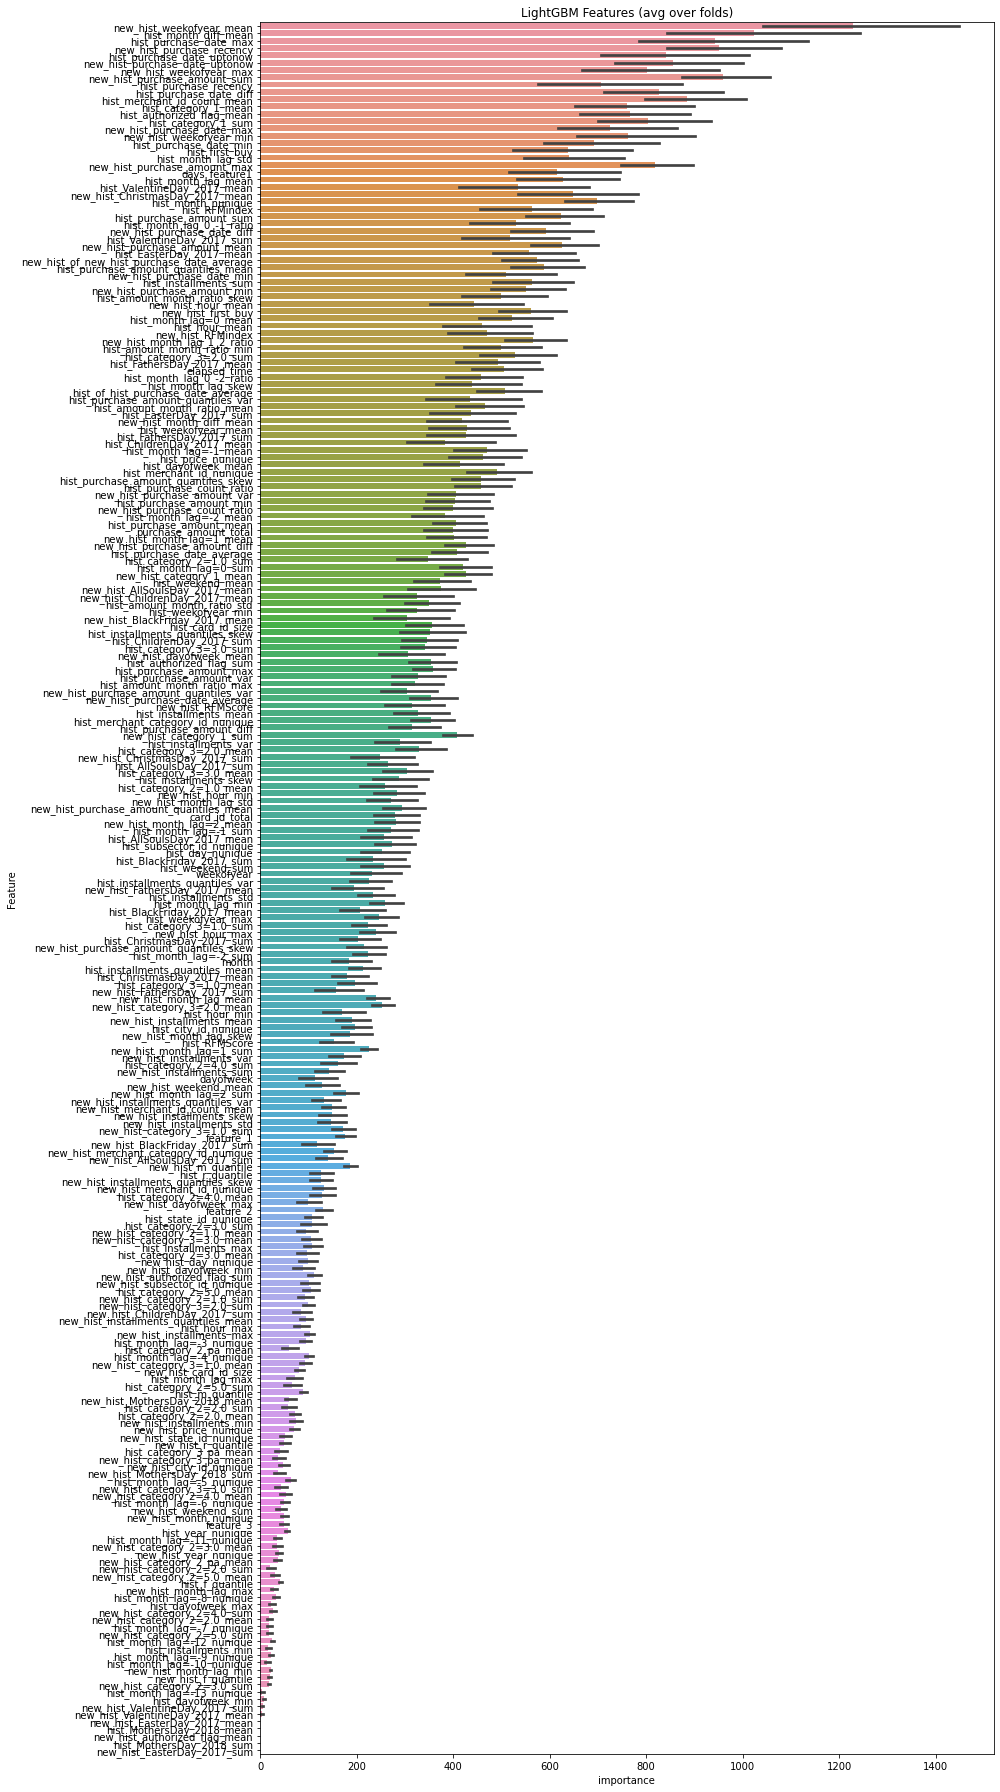

In [ ]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

##LightGBM Score Submission On Kaggle

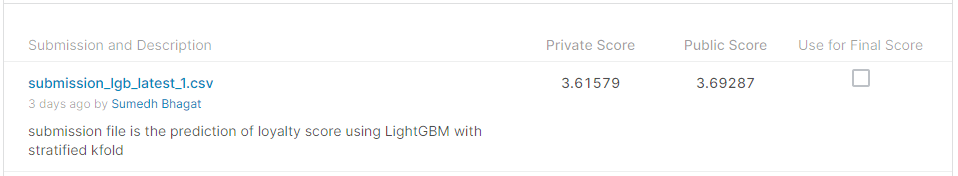

##Conclusion

In [ ]:
x = PrettyTable()
x.hrules = prettytable.ALL

x.add_column('Model',['LightBGM','XGBRegressor','DecisionTreeRegressor','RandomForestRegressor','AdaBoostRegressor',
                      'LinearRegression','Ridge','Lasso'])
x.add_column('Score', ['3.692','3.693','3.807','3.793','3.771','3.876','3.789','3.789'])

print(x)

+-----------------------+-------+
|         Model         | Score |
+-----------------------+-------+
|        LightBGM       | 3.692 |
+-----------------------+-------+
|      XGBRegressor     | 3.693 |
+-----------------------+-------+
| DecisionTreeRegressor | 3.807 |
+-----------------------+-------+
| RandomForestRegressor | 3.793 |
+-----------------------+-------+
|   AdaBoostRegressor   | 3.771 |
+-----------------------+-------+
|    LinearRegression   | 3.876 |
+-----------------------+-------+
|         Ridge         | 3.789 |
+-----------------------+-------+
|         Lasso         | 3.789 |
+-----------------------+-------+
